# AI-enabled Children Story Telling Market Research



In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe import config_manager
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler

from tinytroupe.validation import SimulationExperimentEmpiricalValidator, SimulationExperimentDataset, validate_simulation_experiment_empirically


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: c:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.6.0
Current date and time (local): 2026-01-15 18:59:50
Current date and time (UTC):   2026-01-15 21:59:50

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-5-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
azure_embedding_model_api_version = 2023-05-15
max_completion_tokens = 128000
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
max_concurrent_model_calls = 4
reasoning_effort = high
cache_ap

In [2]:
config_manager.update("action_generator_enable_quality_checks", True)
config_manager.update("action_generator_quality_threshold", 6)

2026-01-15 19:07:06,859 - MainThread(32284) - root - INFO - Updated config: action_generator_enable_quality_checks = True
2026-01-15 19:07:06,864 - MainThread(32284) - root - INFO - Updated config: action_generator_quality_threshold = 6


First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [3]:
control.begin("ai_enabled_children_story_telling_2.cache.json")

2026-01-15 19:07:07,055 - MainThread(32284) - tinytroupe - INFO - Cache file not found on path: ai_enabled_children_story_telling_2.cache.json.


## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [4]:
population_size = 50

demographic_specification = f"""
A uniformly random representative sample of American parents with children aged 4 to 5 years old, who enjoy reading books.
Must reflect the true distribution of characteristics found in such a sample, making it as realistic as possible.
That is to say, the sample must contain the real people found in the population, not the people we would like to.
"""

context = "Market research for a new product."
  

Descriptions and standard questions for the survey.

In [5]:
interviewer_introduction =\
    """
   Artificial Intelligence (AI) can now create compelling stories for young children, tell them aloud and 
   even generate illustrations of the scenes, like a regular book. We are considering creating a "digital story-teller" to leverage 
   this, and would like the opinion of parents. The key idea is that that the child would be able to independently talk to the AI 
   story-teller and request specific stories, anything the child can imagine. Our main doubt is HOW to deliver this technology to 
   the children.
   
   Your task is to order the options based on your preferences. The first option is the one you like the most, and the last option 
   is the one you like the least. So, for example, if you respond with "B, A, C, D, E", it means you prefer option B the most and 
   option E the least.
    """

interviewer_main_question =\
    """ 
    So the main question for you to rank the options is this: what kind of AI-enabled story-telling device would you buy for your very young children (3 to 5 y.o.)? 
    
    Pick from the options below (A, B, C, D, E) and please explain your choices. Here are the details about each option:


     - (A) DEDICATED SINGLE-PURPOSE DEVICE (AUDIO + IMAGES): A single-purpose portable device, where there are no apps or anything else. There is just a single button to turn it ON or OFF, plus a screen, and when ON the child can talk to an animated story-teller, ask stories and the device then tells the requested stories aloud, including related story illustrations too shown on a screen, all on demand. The child can interrupt it at any time too. There is nothing else, no other apps, no other info, nothing, it is just a story-teller device. The stories are told aloud and include static images (like a book, but on the screen). No parent supervision needed.
           PRICE:  Would cost the same as a regular low-end smartphone or tablet.

     - (B) NOTHING: I would rather NOT use ANY AI-enabled device or app for story-telling to my children.

     - (C) APP FOR YOUR EXISTING PHONE OR TABLET (AUDIO + IMAGES): An app for your existing smartphone or tablet, which the child can open any time, and then interact by voice with an animated storyteller. The child can talk to the app, ask for stories and then the stories are told aloud and include related story illustrations (like a book, but on the screen). The child can interrupt it at any time too. No parent supervision needed while using the app.
           PRICE: Would cost the same as any cheap app (US$ 10).

     - (D) DEDICATED SINGLE-PURPOSE DEVICE (AUDIO-ONLY): A single-purpose portable device, where there are no apps or anything else. There is just a single button to turn it ON or OFF, no screens, and when ON the child can talk to it, ask stories and the device then tells the requested stories aloud (no images) on demand. The child can interrupt it at any time too. There is nothing else, no other apps, no other info, nothing,  it is just a story-teller device. The stories are told aloud and have no images or videos - there's just a soft LED light to indicate whether the device is ON or OFF. No parent supervision needed
           PRICE:  Would cost the same as a regular low-end smartphone or tablet.

     - (E) APP FOR YOUR EXISTING PHONE OR TABLET (AUDIO-ONLY): An app for your existing smartphone or tablet, which the child can open any time, and then interact by voice. The child can talk to the app, ask for stories and then the stories would be told aloud on demand, no images nor videos though. The child can interrupt it at any time too. No parent supervision needed while using the app.
           PRICE: Would cost the same as any cheap app (US$ 10).

   IMPORTANT: Please respond with a list of single letter options (A, B, C, D, E), ordered according to your preferences. After that, you can 
   justify your choice. For example:
  
      "Ranking: B, D, C, A, E. Justification: ..."
   """

inner_monologue =\
    """
    I will be honest as I understand they are not here to judge me, but just to learn from me. 
    Such choices depend on many factors, but I will make my best guess, considering my current 
    situation in life, location, job and interests.

    Now I **must** first THINK deeply about the question, consider all the factors that might influence my decision,
    and only then I will TALK with my response to the question as best, as detailed and as honestly as I can.

    I will respect the expected response format, giving first my ranked choices and then justifying that ranking. I MUST adhere to the format strictly,
    saying "Ranking: ..." and "Justification: ...", otherwise my answer might be discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).
    """

Common mechaniss.

In [6]:
results_extractor = ResultsExtractor(extraction_objective="Find the preference order for the options given to the customer." ,
                                     situation="Agent was presented with a few product options and then order them according to his/her preference.", 
                                     fields=["name", "response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as 'OPTION_1-OPTION_2-...-OPTION_N' or 'N/A'(if there is no response or you cannot determine the precise response)."},
                                     verbose=True)

## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [7]:
factory = TinyPersonFactory(
            context=context,
            sampling_space_description=demographic_specification,
            total_population_size=population_size,
        )

In [8]:
people = factory.generate_people(population_size, verbose=True)

2026-01-15 19:11:17,326 - ThreadPoolExecutor-0_0(2228) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 19:11:17,907 - ThreadPoolExecutor-0_0(2228) - tinytroupe - INFO - Sampling dimensions computed successfully.
2026-01-15 19:13:07,633 - ThreadPoolExecutor-0_0(2228) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 19:13:07,779 - ThreadPoolExecutor-0_0(2228) - tinytroupe - INFO - Sampling plan computed successfully.
2026-01-15 19:13:07,875 - ThreadPoolExecutor-0_0(2228) - tinytroupe - INFO - Sample plan has been flattened, contains 50 total samples.
2026-01-15 19:13:25,882 - ThreadPoolExecutor-0_0(2228) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 19:13:40,777 - ThreadPoolExecutor-0_0(2228) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 19:13:59,72

In [9]:
factory.sampling_dimensions

{'sampling_space_description': 'A uniformly random representative sample of American parents with children aged 4 to 5 years old, who enjoy reading books. Must reflect the true distribution of characteristics found in such a sample, making it as realistic as possible. That is to say, the sample must contain the real people found in the population, not the people we would like to be in that population.',
 'dimensions': [{'name': 'parent_age_years', 'range': [16, 60]},
  {'name': 'child_age_years', 'range': [4, 5]},
  {'name': 'parent_gender',
   'values': {'Female, identifies as a mother or woman, primary or co-parent in the household': 0.52,
    'Male, identifies as a father or man, primary or co-parent in the household': 0.47,
    'Non-binary or other gender identity, parent who identifies outside the binary': 0.01}},
  {'name': 'child_gender',
   'values': {'Male child, approximately half the sample': 0.51,
    'Female child, approximately half the sample': 0.49}},
  {'name': 'race_e

In [10]:
factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Typical suburban married mothers in middle-income households who read daily with a 4–5 year old (core majority segment).',
  'sampled_values': {'parent_age_years': [25, 40],
   'child_age_years': [4, 5],
   'parent_gender': 'Female, identifies as a mother or woman, primary or co-parent in the household',
   'child_gender': ['Male child, approximately half the sample',
    'Female child, approximately half the sample'],
   'race_ethnicity': 'Non-Hispanic White',
   'cultural_background': 'White, multi-generational American family, typically suburban or small-town, often with mixed religious traditions and routine holiday gatherings',
   'household_income_annual_usd': 'Household income 50,000 to 100,000 USD, many middle-income households with some discretionary spending for books, subscriptions, and activities',
   'education_level_parent': "Bachelor's degree, often more exposure to child development literature and may buy books deliberately to 

We can request a specific number of people.

A quick look into the folks that were created:

In [11]:
factory.generated_minibios

["Olivia Claire Davis is a 33 year old Kindergarten Teacher, American, currently living in Boulder, Colorado, USA (suburban neighborhood, 15 minutes from downtown, near a public library branch). She's warm, organized, and quietly humorous, often slipping into expressive character voices and small gestures (tucking her hair back, humming while arranging books) to bring stories to life. A committed literacy advocate, she volunteers at library sales, has served on a district working group, and regularly organizes community book events like book picnics and Little Free Library launches while pushing for bilingual storytimes and expanded hours. At home she maintains a curated, rotating shelf of about 85 children's books—sewing protective sleeves, inscribing gift copies, repairing pages, and favoring tactile, durable formats—and uses simple DIY literacy tools (felt puppets, themed trays, a small whiteboard) to extend learning into daily routines. Practical and resilient, she balances lesson 

[DEBUG facet:interests] agents=50 raw_tokens=0 sample=[]
[DEBUG normalize:interests] No tokens provided.
[DEBUG distribution] agents=50 mapping_clusters=0 rev_lookup_size=0
[DEBUG distribution] total_raw_tokens=0
[DEBUG distribution] No mapping available -> raw frequency fallback.
[DEBUG distribution] No flat tokens after flattening.
[DEBUG facet:interests] categories= []
DEBUG Skills: skills_per_agent sample: [['Expertise in early literacy practices: dialogic reading, shared book strategies, promoting vocabulary growth and phonemic awareness.', 'Lesson planning for kindergarten-level literacy and math standards.', 'Small-group instruction and differentiated teaching for mixed-ability classrooms.', 'Assessment skills: anecdotal notes, literacy checklists, and basic informal screening.', 'Classroom management with positive reinforcement and predictable routines.', 'Storytelling and expressive read-aloud techniques (voices, pacing, gestures).', 'Crafting quick literacy-rich activities us

c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\profiling.py:787: RuntimeWarning: Facet 'beliefs' has 2053 categories exceeding cap 6 (incl. 'Other'). Consider investigation.
  warnings.warn(


[DEBUG persona_composition] WARNING facet 'beliefs' categories=2053 > cap+1=7


c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\profiling.py:1116: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


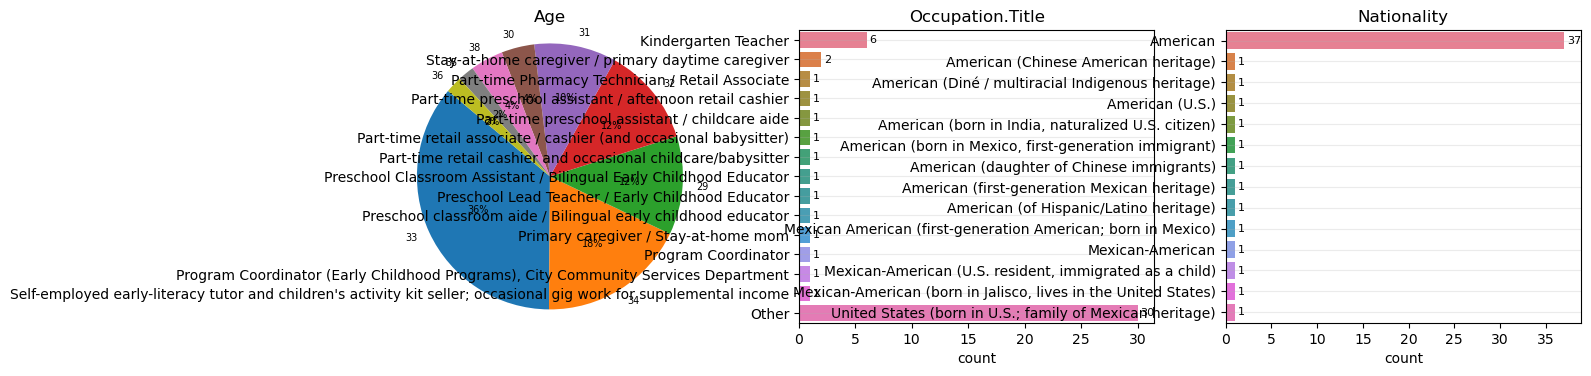

c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\profiling.py:1319: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=(0, 0, 1, 0.97))


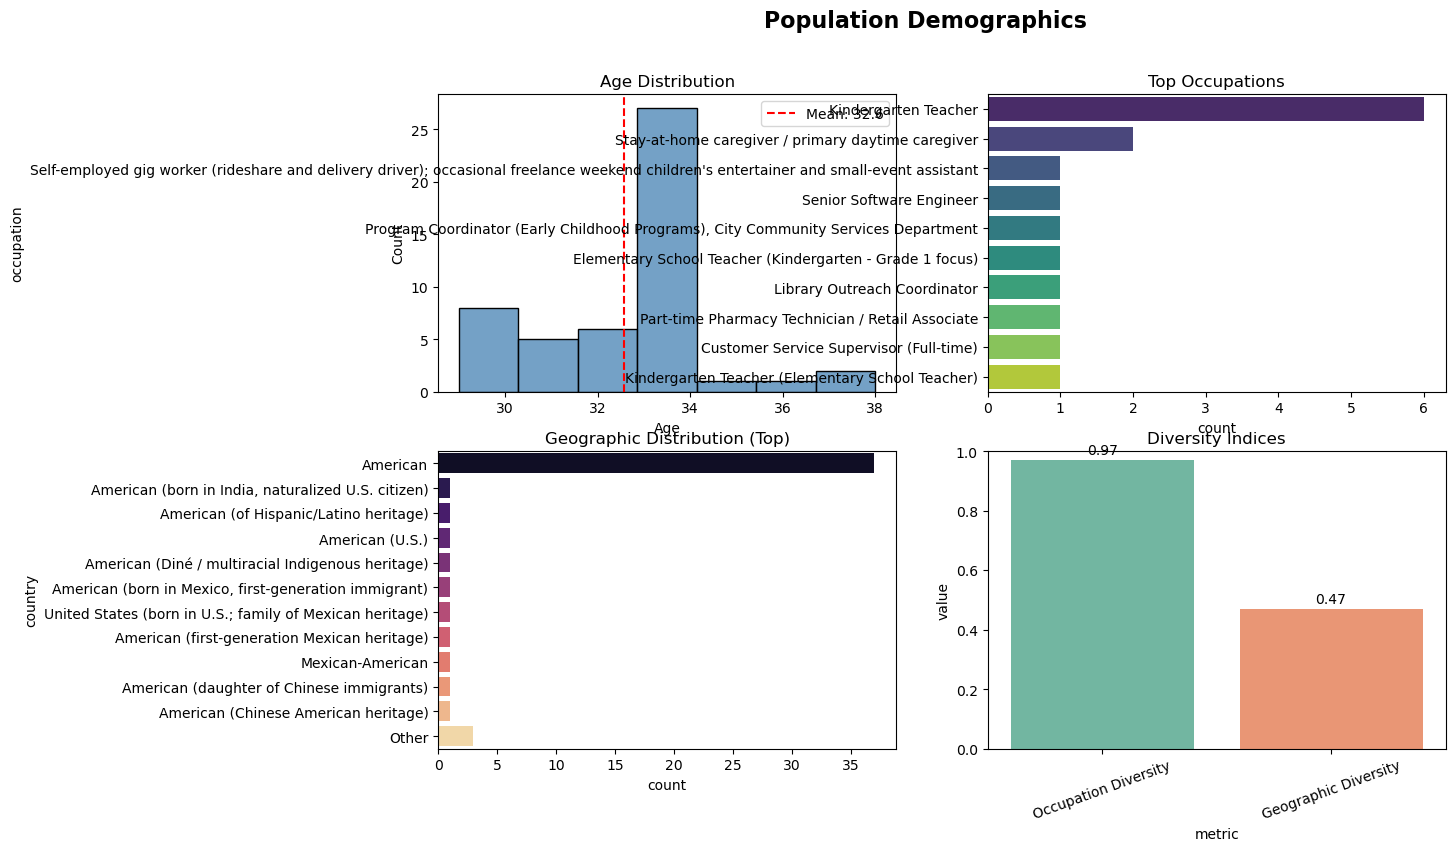

Persona composition keys found: ['interests', 'skills', 'beliefs', 'goals', 'likes_dislikes', 'routines', 'relationship_roles', 'communication_style', 'health', 'personality_traits']
[DEBUG persona_plot] facet 'interests' empty -> hidden
[DEBUG persona_plot] facet 'goals' empty -> hidden
[DEBUG persona_plot] facet 'likes_dislikes' empty -> hidden
[DEBUG persona_plot] facet 'relationship_roles' empty -> hidden


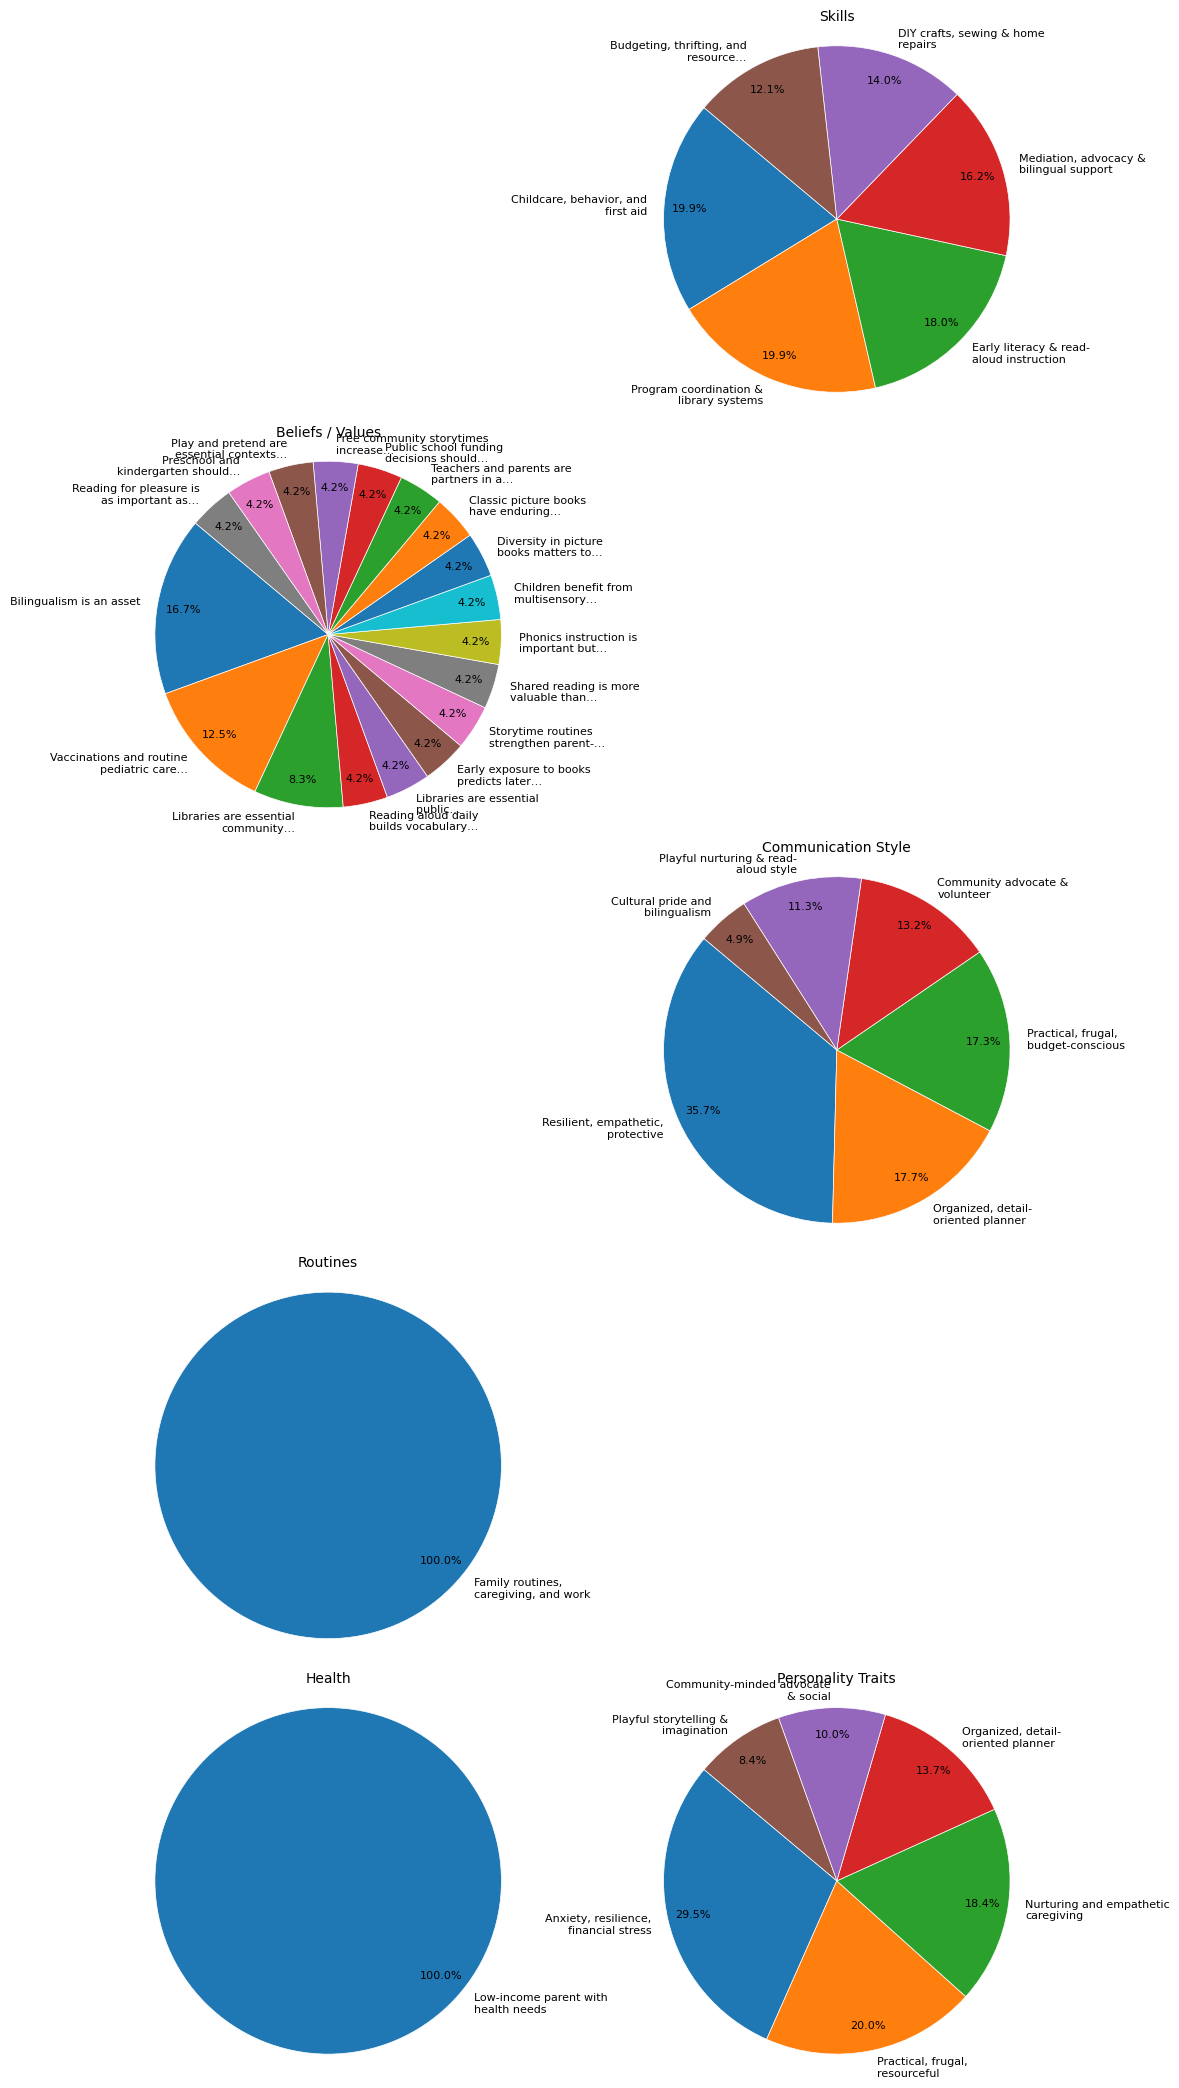

{'age': 29     6
 30     2
 31     5
 32     6
 33    18
 34     9
 35     1
 36     1
 38     2
 Name: count, dtype: int64,
 'occupation.title': Bilingual Preschool Assistant / Early Childhood Classroom Aide                                                                             1
 Certified Nursing Assistant (CNA)                                                                                                          1
 Children's Programs Coordinator / Early Literacy Specialist                                                                                1
 Currently unemployed, actively seeking part-time or full-time work                                                                         1
 Customer Service Supervisor (Full-time)                                                                                                    1
 Early Childhood Classroom Assistant / Head Start Aide                                                                                      1
 Ea

In [12]:
profiler = Profiler()
profiler.profile(people)

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [13]:
control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [14]:
market = TinyWorld(f"Target audience", people, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [15]:
market.broadcast(interviewer_introduction)
market.broadcast(interviewer_main_question)
market.broadcast_thought(inner_monologue)

USER --> Olivia Claire Davis: [CONVERSATION] 
          >     Artificial Intelligence (AI) can now create compelling stories for young children,
          > tell them aloud and     even generate illustrations of the scenes, like a regular book.
          > We are considering creating a "digital story-teller" to leverage     this, and would
          > like the opinion of parents. The key idea is that that the child would be able to
          > independently talk to the AI     story-teller and request specific stories, anything the
          > child can imagine. Our main doubt is HOW to deliver this technology to     the children.
          > Your task is to order the options based on your preferences. The first option is the one
          > you like the most, and the last option     is the one you like the least. So, for
          > example, if you respond with "B, A, C, D, E", it means you prefer option B the most and
          > option E the least.

       + --> Samantha Claire Caldwell

       + --> Noah Elias Kim-Martinez

       + --> ...others...

USER --> Olivia Claire Davis: [CONVERSATION] 
          >       So the main question for you to rank the options is this: what kind of AI-enabled
          > story-telling device would you buy for your very young children (3 to 5 y.o.)?
          > Pick from the options below (A, B, C, D, E) and please explain your choices. Here are
          > the details about each option:        - (A) DEDICATED SINGLE-PURPOSE DEVICE (AUDIO +
          > IMAGES): A single-purpose portable device, where there are no apps or anything else.
          > There is just a single button to turn it ON or OFF, plus a screen, and when ON the child
          > can talk to an animated story-teller, ask stories and the device then tells the
          > requested stories aloud, including related story illustrations too shown on a screen,
          > all on demand. The child can interrupt it at any time too. There is nothing else, no
          > other apps, no other info, nothing, it is just a story-teller device. The stories are
          > told aloud and include static images (like a book, but on the screen). No parent
          > supervision needed.            PRICE:  Would cost the same as a regular low-end smar
          > (...)

       + --> Samantha Claire Caldwell

       + --> Noah Elias Kim-Martinez

       + --> ...others...

Olivia Claire Davis --> Olivia Claire Davis: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests.      Now I **must** first THINK deeply about
                         > the question, consider all the factors that might influence my decision,
                         > and only then I will TALK with my response to the question as best, as
                         > detailed and as honestly as I can.      I will respect the expected
                         > response format, giving first my ranked choices and then justifying that
                         > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                         > and "Justification: ...", otherwise my answer might be discarded. For the
                         > choices, I WILL USE LETTERS (A, B, C, D, E).

Samantha Claire Caldwell --> Samantha Claire Caldwell: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests.      Now I **must** first
                              > THINK deeply about the question, consider all the factors that might
                              > influence my decision,     and only then I will TALK with my
                              > response to the question as best, as detailed and as honestly as I
                              > can.      I will respect the expected response format, giving first
                              > my ranked choices and then justifying that ranking. I MUST adhere to
                              > the format strictly,     saying "Ranking: ..." and "Justification:
                              > ...", otherwise my answer might be discarded. For the choices, I
                              > WILL USE LETTERS (A, B, C, D, E).

Noah Elias Kim-Martinez --> Noah Elias Kim-Martinez: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.      I
                             > will respect the expected response format, giving first my ranked
                             > choices and then justifying that ranking. I MUST adhere to the format
                             > strictly,     saying "Ranking: ..." and "Justification: ...",
                             > otherwise my answer might be discarded. For the choices, I WILL USE
                             > LETTERS (A, B, C, D, E).

Priya Meera Kapoor --> Priya Meera Kapoor: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.      I will respect the expected
                        > response format, giving first my ranked choices and then justifying that
                        > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                        > and "Justification: ...", otherwise my answer might be discarded. For the
                        > choices, I WILL USE LETTERS (A, B, C, D, E).

Laura Bethany Whitmore --> Laura Bethany Whitmore: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.      I
                            > will respect the expected response format, giving first my ranked
                            > choices and then justifying that ranking. I MUST adhere to the format
                            > strictly,     saying "Ranking: ..." and "Justification: ...",
                            > otherwise my answer might be discarded. For the choices, I WILL USE
                            > LETTERS (A, B, C, D, E).

Rachel Morgan Bennett --> Rachel Morgan Bennett: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.      I
                           > will respect the expected response format, giving first my ranked
                           > choices and then justifying that ranking. I MUST adhere to the format
                           > strictly,     saying "Ranking: ..." and "Justification: ...", otherwise
                           > my answer might be discarded. For the choices, I WILL USE LETTERS (A,
                           > B, C, D, E).

Katherine Anne Whitaker --> Katherine Anne Whitaker: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.      I
                             > will respect the expected response format, giving first my ranked
                             > choices and then justifying that ranking. I MUST adhere to the format
                             > strictly,     saying "Ranking: ..." and "Justification: ...",
                             > otherwise my answer might be discarded. For the choices, I WILL USE
                             > LETTERS (A, B, C, D, E).

Julia Meredith Collins --> Julia Meredith Collins: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.      I
                            > will respect the expected response format, giving first my ranked
                            > choices and then justifying that ranking. I MUST adhere to the format
                            > strictly,     saying "Ranking: ..." and "Justification: ...",
                            > otherwise my answer might be discarded. For the choices, I WILL USE
                            > LETTERS (A, B, C, D, E).

Rosa Elena Martínez --> Rosa Elena Martínez: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests.      Now I **must** first THINK deeply about
                         > the question, consider all the factors that might influence my decision,
                         > and only then I will TALK with my response to the question as best, as
                         > detailed and as honestly as I can.      I will respect the expected
                         > response format, giving first my ranked choices and then justifying that
                         > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                         > and "Justification: ...", otherwise my answer might be discarded. For the
                         > choices, I WILL USE LETTERS (A, B, C, D, E).

Alexis Jordan Johnson --> Alexis Jordan Johnson: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.      I
                           > will respect the expected response format, giving first my ranked
                           > choices and then justifying that ranking. I MUST adhere to the format
                           > strictly,     saying "Ranking: ..." and "Justification: ...", otherwise
                           > my answer might be discarded. For the choices, I WILL USE LETTERS (A,
                           > B, C, D, E).

Hannah Claire Whitfield --> Hannah Claire Whitfield: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.      I
                             > will respect the expected response format, giving first my ranked
                             > choices and then justifying that ranking. I MUST adhere to the format
                             > strictly,     saying "Ranking: ..." and "Justification: ...",
                             > otherwise my answer might be discarded. For the choices, I WILL USE
                             > LETTERS (A, B, C, D, E).

Alicia Renee Thomas --> Alicia Renee Thomas: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests.      Now I **must** first THINK deeply about
                         > the question, consider all the factors that might influence my decision,
                         > and only then I will TALK with my response to the question as best, as
                         > detailed and as honestly as I can.      I will respect the expected
                         > response format, giving first my ranked choices and then justifying that
                         > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                         > and "Justification: ...", otherwise my answer might be discarded. For the
                         > choices, I WILL USE LETTERS (A, B, C, D, E).

Carlos Mateo Alvarez --> Carlos Mateo Alvarez: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.      I will respect the
                          > expected response format, giving first my ranked choices and then
                          > justifying that ranking. I MUST adhere to the format strictly,
                          > saying "Ranking: ..." and "Justification: ...", otherwise my answer
                          > might be discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

Maritza Elaine Cruz-Jenkins --> Maritza Elaine Cruz-Jenkins: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.      I will respect the expected
                                 > response format, giving first my ranked choices and then
                                 > justifying that ranking. I MUST adhere to the format strictly,
                                 > saying "Ranking: ..." and "Justification: ...", otherwise my
                                 > answer might be discarded. For the choices, I WILL USE LETTERS
                                 > (A, B, C, D, E).

Aiyana Dawn Yazzie-Hart --> Aiyana Dawn Yazzie-Hart: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.      I
                             > will respect the expected response format, giving first my ranked
                             > choices and then justifying that ranking. I MUST adhere to the format
                             > strictly,     saying "Ranking: ..." and "Justification: ...",
                             > otherwise my answer might be discarded. For the choices, I WILL USE
                             > LETTERS (A, B, C, D, E).

Emily Grace Sullivan --> Emily Grace Sullivan: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.      I will respect the
                          > expected response format, giving first my ranked choices and then
                          > justifying that ranking. I MUST adhere to the format strictly,
                          > saying "Ranking: ..." and "Justification: ...", otherwise my answer
                          > might be discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

Layla Noor Rivera-Singh --> Layla Noor Rivera-Singh: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.      I
                             > will respect the expected response format, giving first my ranked
                             > choices and then justifying that ranking. I MUST adhere to the format
                             > strictly,     saying "Ranking: ..." and "Justification: ...",
                             > otherwise my answer might be discarded. For the choices, I WILL USE
                             > LETTERS (A, B, C, D, E).

Gabriela Elena Morales --> Gabriela Elena Morales: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.      I
                            > will respect the expected response format, giving first my ranked
                            > choices and then justifying that ranking. I MUST adhere to the format
                            > strictly,     saying "Ranking: ..." and "Justification: ...",
                            > otherwise my answer might be discarded. For the choices, I WILL USE
                            > LETTERS (A, B, C, D, E).

Holly Jean Cooper --> Holly Jean Cooper: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.      I will respect the expected
                       > response format, giving first my ranked choices and then justifying that
                       > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                       > and "Justification: ...", otherwise my answer might be discarded. For the
                       > choices, I WILL USE LETTERS (A, B, C, D, E).

Nia Simone Walker --> Nia Simone Walker: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.      I will respect the expected
                       > response format, giving first my ranked choices and then justifying that
                       > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                       > and "Justification: ...", otherwise my answer might be discarded. For the
                       > choices, I WILL USE LETTERS (A, B, C, D, E).

Paige Alexandra Whitman --> Paige Alexandra Whitman: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.      I
                             > will respect the expected response format, giving first my ranked
                             > choices and then justifying that ranking. I MUST adhere to the format
                             > strictly,     saying "Ranking: ..." and "Justification: ...",
                             > otherwise my answer might be discarded. For the choices, I WILL USE
                             > LETTERS (A, B, C, D, E).

Lucu0000eda Elena Rivera --> Lucu0000eda Elena Rivera: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests.      Now I **must** first
                              > THINK deeply about the question, consider all the factors that might
                              > influence my decision,     and only then I will TALK with my
                              > response to the question as best, as detailed and as honestly as I
                              > can.      I will respect the expected response format, giving first
                              > my ranked choices and then justifying that ranking. I MUST adhere to
                              > the format strictly,     saying "Ranking: ..." and "Justification:
                              > ...", otherwise my answer might be discarded. For the choices, I
                              > WILL USE LETTERS (A, B, C, D, E).

Megan Rae Barrett --> Megan Rae Barrett: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.      I will respect the expected
                       > response format, giving first my ranked choices and then justifying that
                       > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                       > and "Justification: ...", otherwise my answer might be discarded. For the
                       > choices, I WILL USE LETTERS (A, B, C, D, E).

Aaliyah Simone Johnson --> Aaliyah Simone Johnson: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.      I
                            > will respect the expected response format, giving first my ranked
                            > choices and then justifying that ranking. I MUST adhere to the format
                            > strictly,     saying "Ranking: ..." and "Justification: ...",
                            > otherwise my answer might be discarded. For the choices, I WILL USE
                            > LETTERS (A, B, C, D, E).

Isabella Mei Carter-Ramos --> Isabella Mei Carter-Ramos: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests.      Now I **must**
                               > first THINK deeply about the question, consider all the factors
                               > that might influence my decision,     and only then I will TALK
                               > with my response to the question as best, as detailed and as
                               > honestly as I can.      I will respect the expected response
                               > format, giving first my ranked choices and then justifying that
                               > ranking. I MUST adhere to the format strictly,     saying "Ranking:
                               > ..." and "Justification: ...", otherwise my answer might be
                               > discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

Jessica Marie Dalton --> Jessica Marie Dalton: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.      I will respect the
                          > expected response format, giving first my ranked choices and then
                          > justifying that ranking. I MUST adhere to the format strictly,
                          > saying "Ranking: ..." and "Justification: ...", otherwise my answer
                          > might be discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

Sage Mei Alvarez-Kim --> Sage Mei Alvarez-Kim: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.      I will respect the
                          > expected response format, giving first my ranked choices and then
                          > justifying that ranking. I MUST adhere to the format strictly,
                          > saying "Ranking: ..." and "Justification: ...", otherwise my answer
                          > might be discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

Luz Marina Ortega --> Luz Marina Ortega: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.      I will respect the expected
                       > response format, giving first my ranked choices and then justifying that
                       > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                       > and "Justification: ...", otherwise my answer might be discarded. For the
                       > choices, I WILL USE LETTERS (A, B, C, D, E).

Amelia Mei Montgomery-Chen --> Amelia Mei Montgomery-Chen: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests.      Now I
                                > **must** first THINK deeply about the question, consider all the
                                > factors that might influence my decision,     and only then I will
                                > TALK with my response to the question as best, as detailed and as
                                > honestly as I can.      I will respect the expected response
                                > format, giving first my ranked choices and then justifying that
                                > ranking. I MUST adhere to the format strictly,     saying
                                > "Ranking: ..." and "Justification: ...", otherwise my answer might
                                > be discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

James Robert Walker --> James Robert Walker: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests.      Now I **must** first THINK deeply about
                         > the question, consider all the factors that might influence my decision,
                         > and only then I will TALK with my response to the question as best, as
                         > detailed and as honestly as I can.      I will respect the expected
                         > response format, giving first my ranked choices and then justifying that
                         > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                         > and "Justification: ...", otherwise my answer might be discarded. For the
                         > choices, I WILL USE LETTERS (A, B, C, D, E).

Ana Lucía Herrera --> Ana Lucía Herrera: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.      I will respect the expected
                       > response format, giving first my ranked choices and then justifying that
                       > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                       > and "Justification: ...", otherwise my answer might be discarded. For the
                       > choices, I WILL USE LETTERS (A, B, C, D, E).

Margot Aiko Bennett-Liu --> Margot Aiko Bennett-Liu: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.      I
                             > will respect the expected response format, giving first my ranked
                             > choices and then justifying that ranking. I MUST adhere to the format
                             > strictly,     saying "Ranking: ..." and "Justification: ...",
                             > otherwise my answer might be discarded. For the choices, I WILL USE
                             > LETTERS (A, B, C, D, E).

Lauren Abigail Hayes --> Lauren Abigail Hayes: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.      I will respect the
                          > expected response format, giving first my ranked choices and then
                          > justifying that ranking. I MUST adhere to the format strictly,
                          > saying "Ranking: ..." and "Justification: ...", otherwise my answer
                          > might be discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

Leila Marisol Tanaka-Rivera --> Leila Marisol Tanaka-Rivera: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests.      Now I
                                 > **must** first THINK deeply about the question, consider all the
                                 > factors that might influence my decision,     and only then I
                                 > will TALK with my response to the question as best, as detailed
                                 > and as honestly as I can.      I will respect the expected
                                 > response format, giving first my ranked choices and then
                                 > justifying that ranking. I MUST adhere to the format strictly,
                                 > saying "Ranking: ..." and "Justification: ...", otherwise my
                                 > answer might be discarded. For the choices, I WILL USE LETTERS
                                 > (A, B, C, D, E).

Kaylee Michelle Abbott --> Kaylee Michelle Abbott: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests.      Now I **must** first THINK
                            > deeply about the question, consider all the factors that might
                            > influence my decision,     and only then I will TALK with my response
                            > to the question as best, as detailed and as honestly as I can.      I
                            > will respect the expected response format, giving first my ranked
                            > choices and then justifying that ranking. I MUST adhere to the format
                            > strictly,     saying "Ranking: ..." and "Justification: ...",
                            > otherwise my answer might be discarded. For the choices, I WILL USE
                            > LETTERS (A, B, C, D, E).

Natalie Brooke Reynolds --> Natalie Brooke Reynolds: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.      I
                             > will respect the expected response format, giving first my ranked
                             > choices and then justifying that ranking. I MUST adhere to the format
                             > strictly,     saying "Ranking: ..." and "Justification: ...",
                             > otherwise my answer might be discarded. For the choices, I WILL USE
                             > LETTERS (A, B, C, D, E).

Evelyn Jia Chen --> Evelyn Jia Chen: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests.      Now I **must** first THINK deeply about the question,
                     > consider all the factors that might influence my decision,     and only then
                     > I will TALK with my response to the question as best, as detailed and as
                     > honestly as I can.      I will respect the expected response format, giving
                     > first my ranked choices and then justifying that ranking. I MUST adhere to
                     > the format strictly,     saying "Ranking: ..." and "Justification: ...",
                     > otherwise my answer might be discarded. For the choices, I WILL USE LETTERS
                     > (A, B, C, D, E).

Sophie Ling Zhang --> Sophie Ling Zhang: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests.      Now I **must** first THINK deeply about
                       > the question, consider all the factors that might influence my decision,
                       > and only then I will TALK with my response to the question as best, as
                       > detailed and as honestly as I can.      I will respect the expected
                       > response format, giving first my ranked choices and then justifying that
                       > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                       > and "Justification: ...", otherwise my answer might be discarded. For the
                       > choices, I WILL USE LETTERS (A, B, C, D, E).

Kayla Jeanette Harper --> Kayla Jeanette Harper: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests.      Now I **must** first THINK
                           > deeply about the question, consider all the factors that might
                           > influence my decision,     and only then I will TALK with my response
                           > to the question as best, as detailed and as honestly as I can.      I
                           > will respect the expected response format, giving first my ranked
                           > choices and then justifying that ranking. I MUST adhere to the format
                           > strictly,     saying "Ranking: ..." and "Justification: ...", otherwise
                           > my answer might be discarded. For the choices, I WILL USE LETTERS (A,
                           > B, C, D, E).

Sofía Isabel Navarro --> Sofía Isabel Navarro: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.      I will respect the
                          > expected response format, giving first my ranked choices and then
                          > justifying that ranking. I MUST adhere to the format strictly,
                          > saying "Ranking: ..." and "Justification: ...", otherwise my answer
                          > might be discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

Erin Louise Miller --> Erin Louise Miller: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.      I will respect the expected
                        > response format, giving first my ranked choices and then justifying that
                        > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                        > and "Justification: ...", otherwise my answer might be discarded. For the
                        > choices, I WILL USE LETTERS (A, B, C, D, E).

Imani Nicole Brooks --> Imani Nicole Brooks: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests.      Now I **must** first THINK deeply about
                         > the question, consider all the factors that might influence my decision,
                         > and only then I will TALK with my response to the question as best, as
                         > detailed and as honestly as I can.      I will respect the expected
                         > response format, giving first my ranked choices and then justifying that
                         > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                         > and "Justification: ...", otherwise my answer might be discarded. For the
                         > choices, I WILL USE LETTERS (A, B, C, D, E).

Claire Elizabeth Parker --> Claire Elizabeth Parker: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests.      Now I **must** first THINK
                             > deeply about the question, consider all the factors that might
                             > influence my decision,     and only then I will TALK with my response
                             > to the question as best, as detailed and as honestly as I can.      I
                             > will respect the expected response format, giving first my ranked
                             > choices and then justifying that ranking. I MUST adhere to the format
                             > strictly,     saying "Ranking: ..." and "Justification: ...",
                             > otherwise my answer might be discarded. For the choices, I WILL USE
                             > LETTERS (A, B, C, D, E).

Maya Chen-Gonzalez --> Maya Chen-Gonzalez: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.      I will respect the expected
                        > response format, giving first my ranked choices and then justifying that
                        > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                        > and "Justification: ...", otherwise my answer might be discarded. For the
                        > choices, I WILL USE LETTERS (A, B, C, D, E).

Mariana Castillo --> Mariana Castillo: [THOUGHT] 
                      >      I will be honest as I understand they are not here to judge me, but
                      > just to learn from me.      Such choices depend on many factors, but I will
                      > make my best guess, considering my current      situation in life, location,
                      > job and interests.      Now I **must** first THINK deeply about the
                      > question, consider all the factors that might influence my decision,     and
                      > only then I will TALK with my response to the question as best, as detailed
                      > and as honestly as I can.      I will respect the expected response format,
                      > giving first my ranked choices and then justifying that ranking. I MUST
                      > adhere to the format strictly,     saying "Ranking: ..." and "Justification:
                      > ...", otherwise my answer might be discarded. For the choices, I WILL USE
                      > LETTERS (A, B, C, D, E).

Monique Renee Carter --> Monique Renee Carter: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests.      Now I **must** first THINK deeply
                          > about the question, consider all the factors that might influence my
                          > decision,     and only then I will TALK with my response to the question
                          > as best, as detailed and as honestly as I can.      I will respect the
                          > expected response format, giving first my ranked choices and then
                          > justifying that ranking. I MUST adhere to the format strictly,
                          > saying "Ranking: ..." and "Justification: ...", otherwise my answer
                          > might be discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

Valentina Mendoza Ramírez --> Valentina Mendoza Ramírez: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests.      Now I **must**
                               > first THINK deeply about the question, consider all the factors
                               > that might influence my decision,     and only then I will TALK
                               > with my response to the question as best, as detailed and as
                               > honestly as I can.      I will respect the expected response
                               > format, giving first my ranked choices and then justifying that
                               > ranking. I MUST adhere to the format strictly,     saying "Ranking:
                               > ..." and "Justification: ...", otherwise my answer might be
                               > discarded. For the choices, I WILL USE LETTERS (A, B, C, D, E).

Hannah Mae Thompson --> Hannah Mae Thompson: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests.      Now I **must** first THINK deeply about
                         > the question, consider all the factors that might influence my decision,
                         > and only then I will TALK with my response to the question as best, as
                         > detailed and as honestly as I can.      I will respect the expected
                         > response format, giving first my ranked choices and then justifying that
                         > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                         > and "Justification: ...", otherwise my answer might be discarded. For the
                         > choices, I WILL USE LETTERS (A, B, C, D, E).

Jordan Alvarez-Kim --> Jordan Alvarez-Kim: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.      I will respect the expected
                        > response format, giving first my ranked choices and then justifying that
                        > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                        > and "Justification: ...", otherwise my answer might be discarded. For the
                        > choices, I WILL USE LETTERS (A, B, C, D, E).

Marisol Reyes-Cruz --> Marisol Reyes-Cruz: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests.      Now I **must** first THINK deeply about
                        > the question, consider all the factors that might influence my decision,
                        > and only then I will TALK with my response to the question as best, as
                        > detailed and as honestly as I can.      I will respect the expected
                        > response format, giving first my ranked choices and then justifying that
                        > ranking. I MUST adhere to the format strictly,     saying "Ranking: ..."
                        > and "Justification: ...", otherwise my answer might be discarded. For the
                        > choices, I WILL USE LETTERS (A, B, C, D, E).

In [16]:
market.run(1)

2026-01-15 20:27:00,975 - MainThread(32284) - tinytroupe - INFO - [Target audience] Running world simulation step 1 of 1.


─────────────────────────────────────────── Target audience step 1 of 1 ───────────────────────────────────────────

2026-01-15 20:27:00,981 - MainThread(32284) - tinytroupe - INFO - [Target audience] No timedelta provided, so the datetime was not advanced.


2026-01-15 20:27:37,249 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:27:38,438 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:27:45,366 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:27:47,819 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:28:09,535 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:28:15,719 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:28:19,980 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Re

Alexis Jordan Johnson acts: [THOUGHT] 
                           > You know, I'm thinking about Isa (4) and little Diego (2) and how we
                           > actually use books at home. My priorities: keep screens limited for the
                           > toddlers, want bilingual stories (Spanish/English), need something
                           > durable and simple so kids can use it when I'm busy at the store or
                           > finishing chores, and it should not be a pricey subscription I can't
                           > keep up with. Also safety/privacy and parental control matter — I don't
                           > want devices that let them wander into other apps or buy stuff. I'll
                           > rank the options with those priorities in mind.

Alexis Jordan Johnson acts: [TALK] 
                           > Ranking: A, D, C, B, E  Justification: A (Dedicated single-purpose
                           > device) — Top pick. I like that it's simple, single-purpose, and
                           > probably low-cost. For my household that matters a lot: Isa and Diego
                           > can ask for a story without me handing over my phone or dealing with
                           > extra apps. If it supports bilingual stories and has kid-safe content,
                           > it's a good supplement to our board books. It still has a screen, which
                           > I watch for, but since it's only for stories and nothing else, it's
                           > easier to set limits.  D (Audio-only storyteller/limited screen) —
                           > Second. If there's an audio-first option (no or very small screen), I
                           > like that for cutting screen time with the littlest ones. Audio can be
                           > great for bedtime and car rides, and it's usually cheaper and more
                           > durable. The downside is Isa likes pictures sometimes, but for routines
                           > and calming time audio is excellent.  C (App on parent's device /
                           > tablet) — Third. It can be convenient and cheaper if I already have a
                           > phone or tablet, and apps can offer lots of bilingual choic (...)

Alexis Jordan Johnson acts: [DONE] 
                           > Finished response; waiting for follow-up questions.

2026-01-15 20:28:54,979 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:28:59,034 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:29:31,894 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:29:44,461 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:29:46,930 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:30:09,218 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:30:37,586 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Re

Rachel Morgan Bennett acts: [THINK] 
                           > I need to be deliberate here. As a kindergarten teacher and a mom of a
                           > 4-year-old, the things that matter most to me are: protecting
                           > childrenu0002s privacy, limiting passive screen time, encouraging
                           > dialogic/shared reading (adult-child interaction), simplicity and
                           > durability for little hands, clear parental controls or a parent-
                           > mediated model, and cost/access (libraries or lending models are
                           > ideal). Iu0002ll weigh each option by those criteria. Iu0002m
                           > especially wary of always-on, app-filled devices that push extra media
                           > or collect data; I remember declining an electronic toy once for
                           > aggressive autoplay and poor privacy. A single-purpose device that
                           > behaves like a book and can be used independently by a preschooler but
                           > doesnu0002t expose them to ads or broad internet content feels safest
                           > and most aligned with how I promote early literacy at home and in
                           > class. I will rank the options with that lens and then explain my
                           > reasoning concisely.

Rachel Morgan Bennett acts: [TALK] 
                           > Ranking: A, D, C, B, E  Justification:  - A (Dedicated single-purpose
                           > device): My top pick. Itu0002s simple, book-like, and limits
                           > distractions. For 3u00025 year olds I want a device that feels like a
                           > familiar shared-reading experience (audio + static illustrations)
                           > rather than a fullscreen, app-filled tablet. If it truly has no extra
                           > apps/ads and a clear privacy stance, it supports independent use
                           > without encouraging excess screen time and reduces data/privacy risks.
                           > - D (parent-linked / library-lending or heavily parent-mediated model):
                           > Second because anything that keeps adults in the loop and can be
                           > borrowed/shared by families/community (library model) is excellent—it
                           > increases access, models adult reading, and reduces household
                           > cost/clutter. Parental mediation supports dialogic reading and helps
                           > children get the most from the stories.   - C (limited-app device with
                           > curated content and parental controls): Middle-ranked. If content is
                           > high-quality and controls are robust, it can work, but my concern is sc
                           > (...)

Rachel Morgan Bennett acts: [DONE] 
                           > Finished — answered ranking task and provided justification.

2026-01-15 20:31:23,351 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:31:30,453 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:31:30,613 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Samantha Claire Caldwell acts: [THINK] 
                              > I need to rank options A–E and then justify my choices.
                              > Considerations from my perspective as a kindergarten teacher and
                              > parent: developmental appropriateness for 3–5 year olds (sensory
                              > engagement, predictable language, visuals for emerging
                              > comprehension), minimising passive screen time, opportunities for
                              > dialogic reading (prompts, repetition, predictable refrains), safety
                              > and privacy (curated content, limited internet/exposure), parental
                              > control/manageability, durability/portability for young children,
                              > and cost/accessibility (library habit and lower-cost solutions).
                              > Weigh pros/cons: single-purpose device with audio+images likely
                              > limits distractions and can emulate a shared read-aloud; audio-only
                              > reduces screen time but loses visual supports useful for 3–5s; full
                              > tablets/apps are flexible but invite distraction and harder to
                              > police; cloud/subscription models raise ongoing cost and
                              > connectivity/privacy concerns; anything needing constant adult
                              > supervision or that is open-ended (unfiltered generation) worries m
                              > (...)

Samantha Claire Caldwell acts: [TALK] 
                              > Ranking: A, C, B, D, E  Justification:  A — Best: A dedicated
                              > single-purpose device (audio + static images) hits the sweet spot
                              > for my kids and my classroom. It’s simple to operate, limits
                              > distractions (no extra apps), and pairs read-aloud with picture
                              > support that helps emerging listeners connect words to images.
                              > Curated, age-appropriate content and the ability for a child to
                              > interrupt are important for shared, participatory storytelling. Also
                              > more likely to respect privacy if it’s offline or tightly
                              > controlled. Overall, it supports dialogic reading and predictable
                              > routines without adding screen clutter.  C — Second: An audio-only
                              > storyteller is appealing because it reduces screen time and
                              > encourages imagination; it’s portable and useful in the car or
                              > during clean-up. My hesitation is that 3–5 year olds often benefit
                              > from visual cues for comprehension and vocabulary, and some children
                              > (or classrooms) need the pictures to stay engaged. Still, audio-only
                              > is a strong option when minimizing screens is the priori (...)

Samantha Claire Caldwell acts: [DONE] 
                              > Finished — waiting for follow-up questions.

2026-01-15 20:31:38,846 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Katherine Anne Whitaker acts: [THINK] 
                             > I need to weigh this carefully. Factors that matter for 3–5 year
                             > olds: limited screen time, durability, simple interface, predictable
                             > routines, opportunities for dialogic interaction, bilingual options,
                             > and parental control/privacy. From my experience as a kindergarten
                             > teacher and a mom, devices that are single-purpose and free of ads
                             > reduce temptation and overstimulation. I also value options that
                             > encourage shared reading or that easily translate into extension
                             > activities (crafts, puppet play, outdoor prompts). Cost and
                             > durability matter for families (and for classroom use), and anything
                             > requiring constant internet or accounts raises privacy concerns. If a
                             > device requires little or no adult setup and yet still allows a
                             > parent to curate content, that's ideal — it supports independent play
                             > but keeps adults in the loop. I'll prioritize safety, low
                             > distraction, and literacy-rich features over novelty bells and
                             > whistles.

Katherine Anne Whitaker acts: [TALK] 
                             > Ranking: A, B, C, D, E  Justification:  A — Top pick. A single-
                             > purpose device (audio + images) that does one thing well is my
                             > favorite. For 3–5 year-olds I want something durable, simple to
                             > operate, and free from distracting apps or ads. A device like this
                             > supports independent story requests while limiting screen/tech creep;
                             > it can still present rich, diverse stories and predictable refrains
                             > that invite participation. From my classroom experience, predictable,
                             > repeatable read-alouds build confidence and vocabulary. My one caveat
                             > is I would want parental controls (or an optional parent pairing) and
                             > offline/locally stored content to protect privacy and let families
                             > use it in cars or on outings.  B — Second. Assuming B is a curated
                             > app or tablet experience with good parental controls, it can be
                             > flexible and lower-cost. Apps can offer bilingual options and easy
                             > updates of new books. Downsides are that tablets invite other apps,
                             > notifications, and more screen time. I’d only recommend this if it’s
                             > very tightly cura (...)

Katherine Anne Whitaker acts: [DONE] 
                             > Finished — waiting for follow-up or to rank with full option
                             > descriptions if provided.

2026-01-15 20:31:46,484 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hannah Claire Whitfield acts: [THINK] 
                             > I need to be systematic: consider child age (3–5), our family's
                             > values (limited passive screen time, lots of shared reading),
                             > safety/privacy, parental control, cost and durability, and whether
                             > the device supports dialogic/shared reading rather than passive
                             > consumption. I also want something that complements library visits
                             > and tactile books—not replaces them. A totally locked-down single-
                             > purpose device seems safer than a multi-app tablet, but audio-only
                             > solutions avoid screens entirely. I'll weigh: 1) how much adult
                             > mediation is required, 2) risk of passive screen time, 3) content
                             > quality and representation, 4) portability/durability/cost. Based on
                             > those priorities I'll produce a ranking and clear justifications.

Hannah Claire Whitfield acts: [TALK] 
                             > Ranking: B, A, C, D, E  Justification:  B — Top choice. (Assuming B
                             > is a parent-controlled or parent-mediated option that lets adults
                             > curate content or use an app to manage the storyteller.) This best
                             > fits my priorities: it keeps parents in the loop, allows careful
                             > curation of stories (representation, language level), and can be set
                             > up to limit screen time or to be audio-first. For a 3–5 year old
                             > (like my Lucy) I prefer solutions that encourage shared reading and
                             > let me prompt questions, pause for predictions, or extend the story
                             > with a song or prop. If B leverages existing devices with strong
                             > parental controls or offers an audio-forward mode, it balances
                             > safety, quality, and cost well.  A — Second. (The dedicated single-
                             > purpose audio+image device.) I like the simplicity and limited-
                             > function approach: no stores, no extra apps, predictable content, and
                             > easier for a child to operate independently. The static illustrations
                             > and read-aloud format echo picture-book reading. My main reservations
                             > are the built-in scr (...)

Hannah Claire Whitfield acts: [DONE] 
                             > Finished — provided ranking and justification.

2026-01-15 20:31:48,808 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Alicia Renee Thomas acts: [THINK] 
                         > Okay, I need to organize my thoughts before I answer. Mateo is 4 — I want
                         > something that is simple for him, affordable, durable, and ideally
                         > bilingual or at least easy to use with Spanish stories. Important
                         > factors: price, ease-of-use (so he can press a button or speak), no ads
                         > or in-app purchases, offline options or low data use (I don't always have
                         > reliable Wi‑Fi), good battery life, parental controls, and limited screen
                         > temptation so it doesn't become too much screen time. I also worry about
                         > fragile devices (tablets break) and subscriptions (monthly costs are hard
                         > on our budget). I like audio/storytelling because we already use
                         > audiobooks in the car. A dedicated, single-purpose device sounds closest
                         > to what I’d trust for independent use. I’ll answer in the required
                         > format: Ranking then Justification.

Alicia Renee Thomas acts: [TALK] 
                         > Ranking: A, B, E, C, D  Justification:  A — Dedicated single-purpose
                         > device (audio + images): My top pick. Simple, no extra apps, less chance
                         > of accidental purchases or ads, and Mateo could use it by himself.
                         > Matches how we already use audiobooks in the car and would be easy for me
                         > to feel comfortable with. Durable and predictable; I don’t have to be
                         > technical to set it up.   B — Smart speaker–style audio storyteller:
                         > Close second. No screen is good for limiting screen time and it’s likely
                         > cheaper. My worry is privacy, needing Wi‑Fi, and possible ads or voice-
                         > activation glitches, but overall a good simple option if it’s ad-free and
                         > has parental controls.   E — Physical/printed hybrid (book + companion
                         > features): I like physical books a lot (we use board books), and this
                         > would keep that tactile feel. If it’s not too expensive or fragile, it’s
                         > a nice choice — but it may need a phone or app to activate extra
                         > features, which adds complexity and cost.   C — General-purpose tablet
                         > with apps: I’d avoid this for regu (...)

Alicia Renee Thomas acts: [DONE] 
                         > Finished response; waiting for next prompt.

2026-01-15 20:31:50,627 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:31:58,536 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Rosa Elena Martínez acts: [THINK] 
                         > I need to weigh practical things first: price, durability (we have four
                         > niños and cosas get tossed), bilingual support (es importante para
                         > Sofía), how much screen time it encourages, whether the child can use it
                         > alone, privacy/internet needs, and ongoing costs or subscriptions. Also
                         > think about cleaning and sharing between siblings. A dedicated device
                         > that only tells stories sounds safer than a full tablet with apps that
                         > invite distractions. An audio-only speaker is good for less screen time
                         > but loses the picture/board-book feeling Sofía likes (lift-the-flap
                         > attention). Plush/toy story devices are cozy but can get dirty or break
                         > and may have limited content. Subscription apps or internet-dependent
                         > services worry me because of recurring costs and data use. So ranking
                         > should favor simple, durable, bilingual, low-cost, and parent-friendly
                         > control.

Rosa Elena Martínez acts: [TALK] 
                         > Ranking: A, B, D, C, E  Justification: A (Dedicated single-purpose
                         > device) is my top choice. It gives stories with pictures and sound
                         > without a bunch of extra apps or notifications, so Sofía can use it
                         > mostly alone, and I don’t have to worry about accidental purchases or too
                         > many screens. If it’s reasonably priced and made for kids (board-book
                         > feeling on screen, easy button), that’s perfecto for my household.  B
                         > (Audio-only smart speaker) is second. I like no-screen options because
                         > less screen time, and it can be cheap and easy to use. The downside is no
                         > pictures — sometimes my chiquita points and wants to see the page — and
                         > many speakers need internet/access that makes me worry about privacy.  D
                         > (Toy/plush storyteller) comes next. I like the cuddly, tactile idea —
                         > it’s comforting at bedtime and shares that hands-on feel my kids like —
                         > but toys can break or get dirty, and they often have smaller libraries or
                         > worse sound quality.  C (Full tablet with apps) is lower because tablets
                         > are expensive and full of dis (...)

Rosa Elena Martínez acts: [DONE] 
                         > Waiting for any follow-up questions.

2026-01-15 20:32:03,542 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Noah Elias Kim-Martinez acts: [THINK] 
                             > Okay — gotta be honest and careful. I only have the full detail for
                             > option A (the dedicated single-purpose device). The rest (B–E)
                             > weren't included in the prompt I just got, so I don't have their
                             > exact specs. I can still give a practical ranking based on common
                             > variants I've seen (phone apps, smart-speaker/cloud devices, tablet-
                             > like sandboxed devices with parental controls, and library/community-
                             > integrated options). My priorities: child safety/privacy (no ads, no
                             > in-app purchases), low friction for a busy parent, durability,
                             > offline/local content or strong parental controls, bilingual support,
                             > and cost. I'll rank assuming those common trade-offs and I’ll flag
                             > that my ordering is tentative if the actual option descriptions
                             > differ.

Noah Elias Kim-Martinez acts: [TALK] 
                             > Ranking: A, D, E, B, C  Justification:  - A (Dedicated single-purpose
                             > device): Top pick. From what I know, a simple, single-purpose
                             > storyteller that has no other apps or ads checks most of my boxes —
                             > safe, low-friction, and predictable. If it lets the kid ask for a
                             > story, shows static book-like images, and can be interrupted, that
                             > feels like a good replacement for a board book when I need a hands-
                             > off moment (and I don’t worry about accidental in‑app purchases or
                             > weird recommendations). Price matters, and if it costs about as much
                             > as a low-end smartphone, that’s believable — still cheaper than
                             > ongoing subscription traps.   - D (tablet-like or device with strong
                             > parental controls / sandboxed content): Second. If this option is a
                             > device or platform that gives parents real control (local content, no
                             > ads, easy language toggles, download-for-offline), I’d prefer it to
                             > phone apps because it keeps the child’s interaction separate from my
                             > personal stuff. It’s more flexible than A (can hold more stories,
                             > bilingual file (...)

Noah Elias Kim-Martinez acts: [DONE] 
                             > Finished — waiting for full option details if available.

2026-01-15 20:32:06,882 - ThreadPoolExecutor-1_3(34456) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Priya Meera Kapoor acts: [THINK] 
                        > I should weigh this carefully: my child is 4, I value limited screen time,
                        > tactile books, bilingual exposure (Hindi/English), and safe, curated
                        > content. Important factors: whether the device encourages parent-child
                        > interaction or replaces it; presence of screens and their impact at
                        > bedtime; parental controls and privacy; offline/ads-free operation;
                        > portability for library/outings; and how much unsupervised access the
                        > child would have. I will rank options by prioritizing child wellbeing,
                        > bilingual support, and practicality for a working parent who sometimes
                        > needs short independent play.

Priya Meera Kapoor acts: [TALK] 
                        > Ranking: A, D, C, B, E  Justification:  A — Top preference. A single-
                        > purpose, curated storyteller device that is ad-free and has a simple
                        > interface is appealing because it reduces distractions and the temptation
                        > of app stores or in-app purchases. Even though it has a screen, the
                        > limited-function design feels safer than a tablet full of apps. For our
                        > family I’d want a bedtime-friendly mode (audio-only) and strong parental
                        > controls (language selection, time limits, content filters). It supports
                        > independent short listening sessions when I need to prep dinner, while
                        > still being predictable and easy to supervise.  D — Second. (Assuming this
                        > is an audio-first speaker/reader with strong parental controls and no
                        > persistent screen.) I prefer audio-only for naps/bedtime and for toddlers
                        > who are easily overstimulated by visuals. A portable, durable speaker that
                        > can play curated, bilingual stories and that integrates with a library or
                        > parent account would be excellent. The lack of screen reduces sleep
                        > disruption and keep (...)

Priya Meera Kapoor acts: [DONE] 
                        > Finished response.

2026-01-15 20:32:17,431 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Laura Bethany Whitmore acts: [THINK] 
                            > I should lay out the priorities a parent like me would use: 1) child
                            > safety and privacy, 2) limited and intentional screen time, 3)
                            > simplicity so a 3–5 year old can use it (or parents can set it and
                            > forget it), 4) content quality that supports language and imagination,
                            > 5) affordability and durability, and 6) easy parental oversight. Keep
                            > in mind my work with early literacy: shared reading is best, but a
                            > device should support—not replace—adult-child interaction. I will rank
                            > options by how well they meet these priorities.

Laura Bethany Whitmore acts: [TALK] 
                            > Ranking: A, C, D, B, E  Justification:  A — Top pick. A dedicated
                            > single-purpose story-teller (audio + images) best matches what I want
                            > for preschoolers: simple interface, limited distractions, lower
                            > privacy risk (ideally offline or tightly controlled), and it supports
                            > independent imaginative play while minimizing screen/app bloat. As a
                            > mom I like things my 4‑year‑old can use without accidentally accessing
                            > other apps (and I like that I can still sit with Maya and talk about
                            > the story afterward).   C — Second. (Assuming C is a constrained
                            > voice-first device or an appliance with strong parental controls.)
                            > Voice interaction with a curated story library can be great for
                            > emergent language if it’s tightly limited and has clear parental
                            > settings. It keeps hands free for puppets or props, which I love to
                            > pair with books. It ranks below A if it shows fewer illustrations or
                            > requires online connectivity that could introduce ads or unpredictable
                            > content.   D — Middle. (If D is a multi-purpose tablet-like option
                            > with pare (...)

Laura Bethany Whitmore acts: [DONE] 
                            > Finished ranking and justification; ready for follow-up questions.

2026-01-15 20:32:20,561 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Julia Meredith Collins acts: [THINK] 
                            > I need to weigh this from my perspective as a library outreach
                            > coordinator and a parent of a 4- and 7-year-old. Key factors: the
                            > kids' ages (3–5 target), limiting passive screen time, the value of
                            > caregiver-mediated reading, equity (cost, library access), privacy and
                            > data concerns (always-listening devices), durability/portability for
                            > backpacks or car rides, bilingual or library-curated content, and
                            > whether the device supports parent control and offline use. I should
                            > rank options by how well they balance child engagement with safety,
                            > accessibility, and alignment with library values. I'll prioritize
                            > audio-first or highly parent-controlled solutions, put single-purpose
                            > devices with a screen next, then options that require general-purpose
                            > tablets/phones or always-connected devices lower because of
                            > distraction and privacy risks.

Julia Meredith Collins acts: [TALK] 
                            > Ranking: B, A, D, C, E  Justification:  B — Top choice for me if it’s
                            > an audio-first, parent-configurable device (or similar): Audio-focused
                            > experiences respect the 3–5 age range (they support language and
                            > imagination without over-relying on screens), are portable and
                            > durable, and are easier to make library-curated or available through
                            > outreach programs. If parents can set limits and choose content (and
                            > the device works offline), it supports equity and reduces
                            > privacy/exposure risks. As a librarian I can imagine circulating or
                            > demoing these in storytime and lending them to families who need
                            > alternatives to tablets.  A — Second because it’s single-purpose and
                            > simple, which I like: a dedicated storyteller device with a
                            > constrained feature set is better than a multi-app tablet. My
                            > reservations are the visible screen and the device being designed for
                            > unsupervised use: children 3–5 do best when a caregiver is involved in
                            > dialogic reading. If A can be configured to encourage caregiver
                            > participation, reduce screen t (...)

Julia Meredith Collins acts: [DONE] 
                            > Waiting for follow-up questions or the full option descriptions to
                            > refine my ranking.

2026-01-15 20:32:26,213 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:32:47,362 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:32:49,889 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:32:51,600 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:33:01,989 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Olivia Claire Davis acts: [THINK] 
                         > I need to be systematic: consider the child's age (3–5), developmental
                         > needs (language, dialogic reading, attention span), screen-time concerns,
                         > parental involvement, safety/privacy, durability/cost, and how the device
                         > supports shared reading vs. independent consumption. I recall option A is
                         > a single-purpose audio+image storyteller with a simple interface and no
                         > other apps. I don't have the verbatim descriptions for B–E in this
                         > stimulus, but typical alternatives include voice-only speakers,
                         > tablet/apps, toy-like devices with subscriptions, and general-purpose
                         > tablets/phones. I'll weigh each option against my priorities: encourages
                         > language and interaction, low distraction, durable for preschool use,
                         > allows parent mediation, and aligns with my belief that shared reading
                         > and print are important. Based on that, I'll order options and then
                         > explain succinctly why I placed each where I did.

Olivia Claire Davis acts: [TALK] 
                         > Ranking: A, C, B, D, E  Justification:  A — Dedicated single-purpose
                         > device (audio + images): My top pick because a simple, single-purpose
                         > storyteller reduces distractions and accidental app/advertising exposure.
                         > For 3–5 year olds, predictable interaction and clear storytelling (with
                         > supportive images) are developmentally appropriate. My only caveat is
                         > that "no parent supervision needed" should not be taken to mean parents
                         > can't engage — I'd want optional parental controls or a way for
                         > caregivers to prompt shared reading. Overall, the focused design best
                         > supports listening skills and sustained attention compared with
                         > multifunction devices.  C — Voice-only smart speaker / audio-first
                         > device: I rank this second because voice interaction is great for
                         > language, imagination, and independent listening (good for car rides or
                         > calm-down time). It encourages oral language without the pull of screens.
                         > Downsides are privacy concerns, variable content quality, and fewer
                         > visual/tactile supports for very young children, so  (...)

Olivia Claire Davis acts: [DONE] 
                         > Finished — awaiting any follow-up or the full option descriptions for a
                         > refined ranking.

2026-01-15 20:33:02,709 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:33:15,600 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:33:21,004 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:33:27,869 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:33:34,186 - ThreadPoolExecutor-1_3(34456) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:33:51,588 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:34:01,094 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Re

Carlos Mateo Alvarez acts: [THINK] 
                          > Okay, pensar rápido: what matters to me as a dad and as someone who
                          > watches money — price, durability (little hands), fácil de usar by a
                          > 4-year-old, bilingual content (Spanish/English), offline options (no
                          > data bills), and que no tenga un montón de apps or account sign-ups. I
                          > also worry about screen time and about something that my niño can
                          > accidentally buy or change settings on. I like audiobooks on my phone or
                          > USB porque las uso en el carro, pero I want something that works cuando
                          > I'm tired and can still feel like reading time. So weigh: simplicity >
                          > cost > offline/bilingual > parental control > no subscriptions.

Carlos Mateo Alvarez acts: [TALK] 
                          > Ranking: A, E, C, B, D  Justification:  A (Dedicated single-purpose
                          > device): Me gusta esto primero. A simple device that only tells stories
                          > and shows static images fits my life — durable, no extra apps, no
                          > complicated accounts, and easy for Mateo to use by himself. If it has
                          > good bilingual content and offline playback, it’s perfecto: I can use it
                          > in the car or at bedtime when I'm wiped from a shift. Low risk for
                          > accidental purchases or distractions.   E (Library / offline / low-cost
                          > community option): I put this second because free or low-cost
                          > library/audiobook solutions are ideal for our budget. I already use
                          > Libby and offline playlists; if there’s a way to get curated story packs
                          > (USB/phone) or library lending that’s easy and child-friendly, that’s
                          > great. Downside: needs adult setup and isn’t always as instant for the
                          > kid alone.  C (Device with parental controls / mixed features): This
                          > could be good — durable hardware plus clear parent controls and
                          > bilingual choices. I rank it middle because many parental-c (...)

Carlos Mateo Alvarez acts: [DONE] 
                          > Finished response.

2026-01-15 20:34:28,117 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:34:33,602 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:34:39,431 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:35:02,361 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:35:12,177 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:35:35,908 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:35:39,464 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Re

Maritza Elaine Cruz-Jenkins acts: [THINK] 
                                 > Think through what matters for my kids (ages 3–5) and for our
                                 > household: cost, durability, simplicity, privacy, bilingual
                                 > support (Spanish/English), how it fits into bedtime/storytime
                                 > routines, and whether it needs constant adult supervision. Also
                                 > consider clinic-parent perspective: families here often prefer
                                 > low-tech, trusted community options and dislike extra
                                 > subscriptions or apps that drain data or have in-app purchases. I
                                 > should rank options by those priorities: 1) safe and simple for a
                                 > child to use alone, 2) affordable or community-supported, 3)
                                 > durable and easy to clean, 4) offers bilingual stories or easy
                                 > toggling, 5) minimal ongoing cost and minimal distraction from
                                 > other apps. I'll use short, clear justifications tied to those
                                 > points.

Maritza Elaine Cruz-Jenkins acts: [TALK] 
                                 > Ranking: A, C, D, B, E  Justification:  A (dedicated single-
                                 > purpose device) — This is my top pick. Simple ON/OFF, no extra
                                 > apps, and just a story-teller fits our bedtime and independent-
                                 > play needs. Little kids can use it without getting into other
                                 > content. If it shows pictures like a book and speaks clearly, it
                                 > works great for routine, and I like that it can be made bilingual
                                 > or have simple language settings. Low tech means fewer surprises,
                                 > less screen-time worry, and less cost creep.   C
                                 > (community/library or shared-device rollout) — I put this second
                                 > if it means the device is given/loaned through trusted places
                                 > (library, school, clinic). Families here trust the library and
                                 > community programs. Free or low-cost community access avoids
                                 > subscription pressure and helps families who can’t afford a
                                 > device. It also keeps content curated and language-friendly.   D
                                 > (interactive toy/device with physical play elements) — Third
                                 > because toys can be very engaging and playful for 3–5 y.o., but
                                 > they can break, get messy, or (...)

Maritza Elaine Cruz-Jenkins acts: [DONE] 
                                 > Finished — provided ranking and reasons.

2026-01-15 20:36:33,957 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:36:39,268 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Aiyana Dawn Yazzie-Hart acts: [THINK] 
                             > Okay, I need to weigh what matters most for my kids and for other
                             > families I know: cost, durability, supervision, bilingual/cultural
                             > content, and how much screen time it uses. I think about Kaya
                             > reaching for things in the car, Lukas getting bored if it's too long,
                             > and Maggie (grandma) who likes to tell stories in Diné. I should
                             > prefer solutions that the library or Head Start can support, that
                             > elders can help make meaningful, and that don't add more tech
                             > headaches or bills. I'll put those priorities into the ranking.

Aiyana Dawn Yazzie-Hart acts: [TALK] 
                             > Ranking: D, A, B, E, C  Justification:   D (community / library /
                             > Head Start delivery, supervised/shared device) — Best for my family
                             > and community because it keeps costs low for parents, brings elders
                             > and librarians into the loop, and lets children use the storyteller
                             > in a social, supervised setting. I trust the library and Head Start
                             > to check cultural accuracy and keep materials age‑appropriate. It
                             > also helps families who can’t buy another device and supports shared
                             > use and repair if something breaks.  A (dedicated single‑purpose
                             > device with audio + simple images) — I like that it’s limited and not
                             > a full tablet. No extra apps means less chance of inappropriate
                             > content or distracting games. If it’s made sturdy, supports offline
                             > stories and some Diné words, and has good parental controls, I’d
                             > consider buying it. Cost is a worry, though; it should be affordable
                             > or available through a subsidy.  B (audio‑only smart storyteller /
                             > speaker) — I like that there’s no screen (less arguing about visuals)
                             > and that it c (...)

Aiyana Dawn Yazzie-Hart acts: [DONE] 
                             > Finished — waiting for next question or feedback.

2026-01-15 20:36:51,065 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:36:57,449 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Emily Grace Sullivan acts: [THINK] 
                          > I need to be methodical because this is the kind of practical decision I
                          > make at work all the time. Factors that matter to me as a parent and a
                          > program coordinator: 1) screen exposure at home (I prefer print and
                          > limited screens for 3-5 year olds), 2) whether the device supports
                          > independent use by a preschooler, 3) opportunities for dialogic
                          > interaction or prompting (does it encourage conversation or just passive
                          > listening), 4) safety/privacy and parental control, 5) durability and
                          > tactile appeal (we favor sturdy, hands-on materials), and 6)
                          > cost/ongoing subscriptions. Also thinking of real-world use cases:
                          > bedtime, car rides, sick-day calm-down, and library/school partnerships.
                          > Now I’ll rank the options with those priorities in mind.

Emily Grace Sullivan acts: [TALK] 
                          > Ranking: B, E, A, D, C  Justification:  - B — Smart speaker, voice-only
                          > (no screen): My top choice. It avoids adding screen time while still
                          > giving rich, narrated stories that a 3–5-year-old can use independently
                          > (especially helpful in the car or for bedtime when I need to sit with
                          > Lily but sometimes can’t read a full book). Good for language
                          > development and imagination because kids have to picture scenes
                          > themselves. Easier to supervise (no hidden apps), usually lower cost
                          > than a full tablet, and easier to control with parental settings. From a
                          > program perspective, audio storytelling pairs well with dialogic prompts
                          > parents can add ("What do you think happens next?") and could be
                          > incorporated into library outreach or sick-day boxes.  - E — Interactive
                          > toy with limited voice responses: Second choice because it aligns with
                          > my preference for tactile, durable materials. A well-designed toy that
                          > tells stories and responds simply could feel like a toy-version of a
                          > storytime prop and be very developmentally appropri (...)

Emily Grace Sullivan acts: [DONE] 
                          > Answered ranking and justification; waiting for follow-up if needed.

2026-01-15 20:36:58,555 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Layla Noor Rivera-Singh acts: [THINK] 
                             > I need to weigh practical factors for a 3–5 year old: emergent
                             > literacy benefits (print awareness, expressive read-aloud), screen-
                             > time limits, bilingual content availability, child independence (can
                             > the child use it without adult help?), safety/privacy, durability for
                             > preschool use, cost, and how well the device supports dialogic
                             > interaction (prompts, questions) versus passive listening. As a
                             > preschool/TK lead and a mom, I prioritize: curated, high-quality
                             > stories; clear limits on other apps/ distractions; visuals that look
                             > like books (to support print awareness) or strong audio-only
                             > narration if it reduces harmful screen exposure; and bilingual
                             > options (English + Spanish and ideally South-Asian language support).
                             > I worry about fully internet-connected multi-app tablets that invite
                             > endless browsing or ads. A dedicated single-purpose device (like A)
                             > seems promising because it reduces distractions and can be designed
                             > durable and bilingual. An audio-only option is attractive for lower
                             > screen exposure but loses p (...)

Layla Noor Rivera-Singh acts: [TALK] 
                             > Ranking: A, C, B, E, D  Justification: A — I put the dedicated
                             > single-purpose device first. For preschoolers I want something that
                             > feels like a book-with-voice: curated stories, static images that
                             > read like illustrations, and no extra apps or internet distractions.
                             > It supports emergent literacy (pictures + narration), can be made
                             > durable for little hands, and is easiest for independent use. If it
                             > includes bilingual story options and clear parental settings, it
                             > checks most of my priorities as a teacher and parent.  C — Second is
                             > an audio-first, screen-minimal option (audio smart-speaker style). I
                             > like that it minimizes screen time and can have expressive narrators
                             > — great for car rides and calming nighttime listening. I rank it
                             > below A because it lacks visual/print cues that support early print
                             > awareness and joint book reading, but it’s a very strong choice when
                             > reducing screens is a top priority.  B — A parent-controlled
                             > app/tablet solution comes next. If well-curated with strong parental
                             > controls and a simpl (...)

Layla Noor Rivera-Singh acts: [DONE] 
                             > Finished response.

2026-01-15 20:37:08,424 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Holly Jean Cooper acts: [THINK] 
                       > Okay — I gotta think this through like I would if I was spendin' my last
                       > few dollars. Main things that matter to me: price, who pays for it (library
                       > or me), how tough it is (kids tear things up), whether it needs my
                       > phone/data, whether the kids can use it by themselves, and if it's gonna
                       > steal their attention with screens. I keep seein' Miss Rivera at the
                       > library handin' out things that actually get used, and I remember that my
                       > 4-year-old loves touchy books and trucks. Also thinkin' of Head Start
                       > rules, safety/privacy (I don't want weird recordings), and that I don't
                       > have lots of spare time to fiddle with tech. So I'll pick based on
                       > durability, low cost or free access, low need for grown-up tech help, and
                       > low-screen preference for preschoolers.

Holly Jean Cooper acts: [TALK] 
                       > Ranking: C, D, A, B, E  Justification: C — My top pick. If this means
                       > something run through the library or community center (free or loaned),
                       > that's the best for folks like me. Miss Rivera can show the kids how to use
                       > it, there's no extra cost, and I don't have to worry about data or buyin' a
                       > gadget. Free community access also means I won't feel bad if it gets beat
                       > up a little.  D — Second. An audio-only device (like a little speaker) that
                       > kids can talk to would be handy — no screen to break or distract 'em, and
                       > it can work hands-free during diaper changes or car rides. I'd still worry
                       > a bit about privacy and who pays for it, but it's practical and cheaper
                       > than a tablet.  A — Third. A single-purpose device that's simple sounds
                       > nice because it won't have a bunch of apps to tempt the kids. But any
                       > device with a screen worries me: screens get scratched, batteries die, and
                       > kids drop stuff. If it was cheap and rugged and the library or Head Start
                       > could provide it, I'd be more into it. As my own buy, maybe not unle (...)

Holly Jean Cooper acts: [DONE] 
                       > Finished — waiting for any follow-up questions.

2026-01-15 20:37:17,581 - ThreadPoolExecutor-1_3(34456) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Paige Alexandra Whitman acts: [THINK] 
                             > Okay — I need to organize my thoughts before answering. Important
                             > factors for a 3–5 year-old: emergent literacy (they benefit from
                             > pictures paired with read-aloud), device durability and simplicity
                             > (little hands, fussy routines), minimal distractions (avoid lots of
                             > apps or ads), parental control and content curation (I want to know
                             > what my child hears), affordability, and how the device supports
                             > shared reading rituals (we read together a lot at bedtime). As a
                             > kindergarten teacher and a parent, I value devices that encourage
                             > interaction rather than passive screen-staring. Also consider
                             > accessibility — offline use or local content is a plus in case Wi-Fi
                             > is spotty. Privacy and safety matter; devices that record or piped-
                             > through internet content worry me unless there are strong safeguards.
                             > Finally, think about independence vs. parent involvement: something
                             > simple that a child can operate is great, but I still want the option
                             > to jump in and use it together. Based on those priorities, I should
                             > favor single-purpose (...)

Paige Alexandra Whitman acts: [TALK] 
                             > Ranking: A, C, B, E, D  Justification:  A (Dedicated single-purpose
                             > device with audio + images) — Top choice. Matches what I look for as
                             > a teacher and parent: clear pictures paired with read-aloud support
                             > comprehension for emergent readers, a single-purpose device limits
                             > distractions and apps, and the simple interface is appropriate for
                             > little hands. If it’s durable and designed for kids (no hidden menus,
                             > no ads), it easily supports independent requests but still fits into
                             > our shared-reading routines. Affordable one-time cost is appealing
                             > compared with subscriptions.  C (Curated parent-controlled
                             > app/device) — Second. Offers the flexibility and rich illustrations
                             > that help language development, and good parental controls mean I can
                             > curate content and limit screen time. I’d choose this only if the app
                             > is clearly kid-friendly, offline-capable, and not full of extra games
                             > or prompts that pull focus away from the story.  B (Voice-
                             > only/speaker-based storyteller) — Third. A safe, hands-free option is
                             > nice for car r (...)

Paige Alexandra Whitman acts: [DONE] 
                             > Finished — waiting for any follow-up questions.

2026-01-15 20:37:21,120 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Gabriela Elena Morales acts: [THINK] 
                            > I need to answer clearly and in the exact format they asked: "Ranking:
                            > ..." and "Justification: ..." using letters A–E. Think about what
                            > matters to me as a preschool aide and a mamá: my kids' ages (1 and 4),
                            > limits on screen time, bilingual content (Spanish/English), safety (no
                            > ads, no random internet), affordability, portability for library/park
                            > trips, and whether the device supports shared reading or at least
                            > parental control. I also value community access (library) but need
                            > something usable at home when I work or run errands. I prefer print
                            > books but accept a simple, controlled digital storyteller for
                            > independent moments if it protects bilingual language modeling and is
                            > low-cost. So weigh: 1) single-purpose, offline, no-app devices
                            > (safe/simple) 2) parent-curated/recordable options that let me add my
                            > voice or choose Spanish 3) physical toys with limited content (durable
                            > but limited) 4) library/kiosk solutions (good but not always available
                            > at home) 5) open tablet/smartphone apps with internet/ads (least pr
                            > (...)

Gabriela Elena Morales acts: [TALK] 
                            > Ranking: A, C, D, E, B  Justification: A — Top choice. A single-
                            > purpose device that only tells stories (audio + images) feels most
                            > child-safe and simple for mi niña de 4 años to use alone when I need a
                            > short break. No apps or internet means no ads or accidental purchases,
                            > and if the stories are available in Spanish and English it's great for
                            > bilingual exposure. It also would be affordable and portable for the
                            > park or car. I still prefer shared reading, but this is a good backup
                            > that protects children from unsafe content.  C — Second. I like
                            > options that let parents customize or record stories (so children hear
                            > a familiar voice) or let me choose language and control content. Being
                            > able to add my own short prompts or library-recommended titles would
                            > support Spanish language modeling and feel personal and low-cost.
                            > Parental control is key here.  D — Third. A durable interactive
                            > toy/story-player is okay — good for toddlers (like my 1-year-old)
                            > because it can be rugged and simple. But many toys have limited conten
                            > (...)

Gabriela Elena Morales acts: [DONE] 
                            > Finished response; waiting for next prompt.

2026-01-15 20:37:24,164 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Lucu0000eda Elena Rivera acts: [THINK] 
                              > I need to think step-by-step about what matters for our family and
                              > for Mateo (age 4). Important criteria: cost (we're on a tight
                              > budget), durability (kids destroy fragile stuff), bilingual support
                              > (Spanish + English), offline/usability with limited data, child
                              > independence (can Mateo use it alone?), safety/privacy (no always-on
                              > internet I can't control), and community/trusted sources
                              > (library/teachers recommend).  Evaluate options in my head by those
                              > criteria:  - A (dedicated single-purpose device): + Simple, little
                              > to no setup, offline possible, no extra apps, easy for a young child
                              > to use alone, less chance of accidental purchases or distractions,
                              > sounds affordable. - Might be limited in content breadth but better
                              > than nothing. Fits my finances and need for simplicity.  - D
                              > (library or community-hosted solution): + Free access, staff can
                              > help, bilingual support likely, trusted by me (Ms. Rosa, Head
                              > Start). - Requires going to library, not available at home anytime,
                              > depends on library hours/transportation bu (...)

Lucu0000eda Elena Rivera acts: [TALK] 
                              > Ranking: A, D, C, B, E  Justification:  A — Dedicated single-purpose
                              > device: My top pick. It sounds simple, affordable, and child-
                              > friendly. Mateo can press a button and get a story without me
                              > needing to fiddle with apps or Wi‑Fi. For our limited data plan and
                              > my schedule, a durable, offline-ish device that avoids accidental
                              > purchases or distractions is exactly what I would trust most. It
                              > supports independent play and keeps things calm at bedtime or in the
                              > car.   D — Community/library-hosted device or program: Second place
                              > because I trust the library and Ms. Rosa; they give bilingual
                              > choices and in-person help, and many things there are free. I like
                              > that staff can model read-alouds and give printed tips. The downside
                              > is I have to get there (transportation, hours), but for families
                              > like mine this is a great, low-cost option.   C — Smart speaker /
                              > home assistant: Middle. It can be easy to use at home and answers
                              > quickly, but it needs steady internet and I worry about privacy,
                              > ads, or unexpected content. It’s fin (...)

Lucu0000eda Elena Rivera acts: [DONE] 
                              > Waiting for next question or feedback.

2026-01-15 20:37:29,306 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:37:37,890 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Nia Simone Walker acts: [THINK] 
                       > Alright, lemme think this through like I promised. I gotta weigh what
                       > matters to me as a working mom with two little ones (4 and 2), tight
                       > budget, and love for books — so safety, simplicity, durability, cost (no
                       > sneaky subscriptions), and whether the device encourages real shared
                       > reading or just screen-staring. Also gotta think about independent use (so
                       > Aaliyah can play while I'm on a shift), parental control, representation of
                       > Black kids in stories, and ease of repair/replace if it gets dropped. I
                       > prefer devices that don't add monthly bills, that don't have a million apps
                       > or ads, and that look/feel like a book more than a toy. Okay — ready to say
                       > my ranking and explain why, in the format they asked for.

Nia Simone Walker acts: [TALK] 
                       > Ranking: A, D, B, C, E  Justification: A — Dedicated single-purpose device
                       > (best): Baby, for real — this one checks the boxes for me. Simple for a
                       > 3–5-year-old to use by themself, no extra apps or ads to get lost in, and
                       > it behaves like a storybook with pictures and voice. That means less
                       > supervision needed when I’m at work or grabbing a minute. I like that it
                       > limits screen-time temptations and won’t try to upsell me. Durable,
                       > predictable, and likely cheaper up-front than a full tablet. Also easier to
                       > gift or keep in the car for waits without risking my phone or a tablet full
                       > of other stuff.  D — (second): I’d pick a voice-first device with good
                       > parental controls next. If it’s mostly audio with safe, kid-focused content
                       > and the ability for parents to set limits, that’s helpful — especially for
                       > car rides or night-time soothing. It’s more flexible than A, but I worry
                       > about privacy and accidental access to other content unless the controls
                       > are clear and strong.  B — (third): An app on an existing tablet/phone is
                       > (...)

Nia Simone Walker acts: [DONE] 
                       > Finished — provided ranking and justification.

2026-01-15 20:37:47,273 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:38:01,156 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Megan Rae Barrett acts: [THINK] 
                       > All right, thinkin' this through like I promised. My kids' ages (7, 4, 2)
                       > matter — Eli and Noah need something simple and sturdy. Money and internet
                       > are tight off and on; I worry about ongoing subscriptions, in-app
                       > purchases, and ads. I prefer things that are offline or limited, durable,
                       > and that let kids enjoy a story without me havin' to hover. I WILL give the
                       > answer exactly as asked: say "Ranking: ..." then "Justification: ..." with
                       > letters A–E.

Megan Rae Barrett acts: [TALK] 
                       > Ranking: A, C, B, D, E  Justification:   - A (Dedicated single-purpose
                       > device): This is my top pick. If it's really just a story-teller with one
                       > button, no apps, no purchases, and no extra junk, that's perfect for my
                       > crew. It's easy for a 4-year-old to use on their own, and I don't gotta
                       > worry about accidental buys or weird ads. Durability and simplicity matter
                       > when you got little hands and not much time to babysit a screen. If it
                       > shows pictures like a board book and talks aloud, that hits the sweet spot
                       > — like a library book that won't get torn.    - C (second place): If C is a
                       > simple, low-cost audio device or a child-focused gadget that limits extra
                       > features (no store, little or no internet required), I'd put it here. I
                       > like audio for car rides and while doin' chores, and it keeps screen time
                       > down. I lose a little ground compared to A if C doesn't show any pictures,
                       > because my kids love lookin' at pictures while I read. Still, a cheap,
                       > offline audio storyteller is useful.    - B (middle): Something like a s
                       > (...)

Megan Rae Barrett acts: [DONE] 
                       > Finished response.

2026-01-15 20:38:03,915 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:38:04,255 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:38:17,607 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:38:31,657 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:38:38,218 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:38:38,904 - ThreadPoolExecutor-1_3(34456) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:38:50,292 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Req

Aaliyah Simone Johnson acts: [THINK] 
                            > Okay, I gotta think like a busy mom in Brooklyn with two little ones,
                            > tight budget, and library habits. Important factors: price and ongoing
                            > cost, durability (kids will drop/chew stuff), ease-of-use for a 3–5
                            > year old (and a 2-year-old who likes tactile things), need for little-
                            > to-no supervision, offline or low-data operation, privacy/no ads,
                            > simple controls (one button), battery life and charging,
                            > representation (stories that show Black families), and whether the
                            > device can be borrowed or demoed at the library/church. Also think
                            > about convenience: portable vs something that needs constant internet
                            > or app updates. Weigh those and pick top choices.

Aaliyah Simone Johnson acts: [TALK] 
                            > Ranking: A, C, B, E, D  Justification:  A (Dedicated single-purpose
                            > device) — Top pick. Simple and focused is what I want for my kids. No
                            > extra apps or distractions, easy for a toddler to use, and less chance
                            > of accidental purchases or inappropriate content. If it’s durable,
                            > shows illustrations (like a picture book), and works offline or with
                            > minimal data, that’s perfect. No need to babysit an app while I’m
                            > cooking or catching a quick break between shifts. Also I like the idea
                            > that it looks and works like a real storytime device — something Emani
                            > can ask to tell a story herself.  C (Audio-only storyteller / smart-
                            > speaker style) — Second. Voice-only can be great: hands-free, cheap-
                            > ish, and easy for little ones to interact with. But I’m worried about
                            > privacy, ads, or accidental web searches if it’s connected to a big
                            > company. Still better than full tablets because it’s lower fuss and
                            > usually cheaper. If it’s offline or library-backed and ad-free, I’d be
                            > comfortable.  B (Device with images plus apps / more featu (...)

Aaliyah Simone Johnson acts: [DONE] 
                            > Finished — waiting for next question or feedback.

2026-01-15 20:38:51,317 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:39:09,694 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:39:14,930 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:39:18,413 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:39:29,236 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Isabella Mei Carter-Ramos acts: [THINK] 
                               > Okay — I need to answer clearly and honestly, keeping Lucas, our
                               > routines, and my values in mind. Key factors: parental co-use (I
                               > prefer doing storytime together), limited ads/in‑app purchases,
                               > bilingual support (some Mandarin/Spanish exposure),
                               > durability/portability for car or walks, and cost. I should favor
                               > options that encourage interaction and don't replace adult-child
                               > reading. I'll rank A–E accordingly and explain each choice briefly,
                               > mentioning practical tradeoffs (nap-time use, library habits,
                               > budget).

Isabella Mei Carter-Ramos acts: [TALK] 
                               > Ranking: D, A, C, E, B  Justification:  D — Top choice. If D is the
                               > option that encourages parent/guardian involvement (good parental
                               > controls, designed for co‑use, and avoids ads/in‑app purchases)
                               > it's ideal for us. I value devices that support read‑aloud
                               > interaction rather than replacing it — Lucas learns more when we do
                               > stories together, and I want something that lets me switch between
                               > Mandarin and English easily. Practical benefits: supports routines
                               > (short, predictable sessions at nap/bedtime), fewer surprises on
                               > the bill, and less chance of the device becoming a solo babysitter.
                               > A — Second. A single‑purpose storyteller device (simple on/off, no
                               > extra apps) is appealing because it's predictable, less likely to
                               > push ads or downloads, and easier for a toddler to use. I like the
                               > simplicity for car rides or when I need a short break. My only
                               > worry is if it encourages unsupervised solo use too often — I
                               > prefer it as a complement to shared reading, not a replacement.  C
                               > — Mid choice. If C is an audio‑first sm (...)

Isabella Mei Carter-Ramos acts: [DONE] 
                               > Finished — submitted my ranking and reasoning.

2026-01-15 20:39:42,408 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:40:02,561 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:40:04,117 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:40:15,228 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:40:36,714 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:40:40,103 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:41:02,419 - ThreadPoolExecutor-1_3(34456) - httpx - INFO - HTTP Req

Jessica Marie Dalton acts: [THINK] 
                          > So — I gotta think about what's most important for a preschooler and for
                          > a family like mine: safety, limited screen time, durability, simplicity
                          > so my 4-year-old can use it without constant help, and the price we can
                          > actually afford. I also want something that doesn't feel like a fancy
                          > marketing gadget, because I don't trust expensive gimmicks. Parental
                          > controls or a way for me to supervise are big, plus offline or low-data
                          > options are nice since our internet can be spotty. I'll keep those
                          > factors in mind when I give the ranking.

Jessica Marie Dalton acts: [TALK] 
                          > Ranking: A, D, C, B, E  Justification: - A (Dedicated single-purpose
                          > device): My top pick. So much about this appeals to me — it's simple,
                          > kid-focused, and there's nothing else for my kid to get into. For a 3–5
                          > year old who likes to press buttons and tell stories, a device that's
                          > just a storyteller feels safe and easy. No extra apps, fewer
                          > distractions, and likely better for limiting screen time. If it's rugged
                          > and priced like a low-end smart gadget, that's even better for a
                          > household on a tight budget.  - D (Second choice): I put this second
                          > because I imagine it gives a good balance of storytelling features with
                          > reasonable parental controls and reliability. If it lets me set limits
                          > and review activity, or has a parent-controlled mode, that matters a
                          > lot. I like options that let the child be independent but still let me
                          > step in when needed.  - C (Middle): This is okay if it leans toward
                          > curated content and clear parental settings, but I worry about
                          > subscriptions or hidden costs. If it needs steady internet or (...)

Jessica Marie Dalton acts: [DONE] 
                          > Finished my ranking and explanation.

2026-01-15 20:41:55,615 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:41:56,799 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:42:04,019 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:42:13,891 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Sage Mei Alvarez-Kim acts: [THINK] 
                          > I should weigh this like I would for families I work with: consider age
                          > (3-5), attention span, limits on screen time, bilingual/representation
                          > needs, privacy/data collection, parental control and involvement,
                          > durability/portability for preschool and car trips, and price. As a
                          > preschool lead and a parent I prefer solutions that support interactive
                          > language (voice/dialogic opportunities), minimize passive screen
                          > exposure, allow parents to curate content (especially authentic
                          > bilingual stories), and protect children's data. I'll order options by
                          > how well they meet those criteria and then explain each choice.

Sage Mei Alvarez-Kim acts: [TALK] 
                          > Ranking: B, A, C, D, E  Justification:   B — Top choice (audio-first,
                          > screen-free or mostly screen-free device): For my 3–5 year-old learners
                          > I value voice interaction and imagination. An audio-first device limits
                          > passive visual screen time, encourages children to visualize the story
                          > (great for language development), and is easier to use in car or
                          > classroom settings. If it offers authentic bilingual story libraries,
                          > offline mode, clear parental controls, and strong privacy (no data
                          > collection), it fits my priorities: bilingual exposure, dialogic
                          > extension, and safety. Durable and single-purpose devices also reduce
                          > temptation to use other apps.  A — Second (dedicated single-purpose
                          > device with images): I like that it’s single-purpose and likely curated,
                          > which reduces commercialized content and distraction. Illustrations can
                          > scaffold comprehension and prompt conversation, which is helpful for
                          > preschoolers. My reservation is the addition of a screen: it can
                          > increase passivity or encourage longer-than-ideal viewi (...)

Sage Mei Alvarez-Kim acts: [DONE] 
                          > Finished — waiting for any follow-up questions or requests for more
                          > detail about any option.

2026-01-15 20:42:14,352 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


James Robert Walker acts: [THINK] 
                         > Alright — gotta think this through like I would if I was buyin' somethin'
                         > for Liam. Main things that matter round here: something that won't break,
                         > ain't full of junk apps or ads, shows pictures so a four-year-old can
                         > follow along, don't cost too much up front or every month, and works even
                         > if the internet's spotty. Also I don't want to be handin' over my phone
                         > all the time. I'll weigh durability, simplicity, visuals, parental
                         > control, price, and offline use.

James Robert Walker acts: [TALK] 
                         > Ranking: A, C, D, B, E  Justification:  A (Dedicated single-purpose
                         > device) — Top pick. Sounds like a tough little gadget that does one job:
                         > tell stories with pictures. That's right up my alley. Durable, simple for
                         > a kid to use, no junk apps, and parents don't gotta babysit an app store.
                         > Looks like the closest thing to a real book but easier for a kid to
                         > operate. Good for a small-town family with limited time and patience for
                         > gizmos.  C (Audio-only smart speaker) — Second. I like that it's simple
                         > and hands-free, and cheaper maybe, but my little man still points at
                         > pictures and likes lookin' while I read. Audio-only misses that. Still
                         > better than a full-on tablet since it's less distracting and more robust
                         > than a phone.  D (Parent-controlled app on a phone) — Middle. Handy for
                         > occasional use and easy to update, but I don't want to give my phone to a
                         > toddler or make every story time depend on me bein' right there with my
                         > phone. Also phones get used for a hundred other things and can break or
                         > get lost. Could wor (...)

2026-01-15 20:42:14,405 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


James Robert Walker acts: [DONE] 
                         > Finished my response; waiting for any follow-up questions.

Luz Marina Ortega acts: [THINK] 
                       > I need to organize my thoughts: consider the kids' ages (3-5), the
                       > importance of maintaining Spanish at home, screen-time concerns, safety (no
                       > ads, no accidental purchases), cost and portability, and whether the device
                       > lets a child use it independently or needs parental setup. Also think about
                       > library values — free, low-cost, culturally appropriate resources — and my
                       > own experience with families who can't afford subscriptions. I will rank
                       > the options keeping those priorities in mind and then explain briefly why,
                       > following the required format ('Ranking:' then 'Justification:').

Luz Marina Ortega acts: [TALK] 
                       > Ranking: A, B, D, C, E  Justification:  A — Best overall for my
                       > family/library needs: single-purpose, simple interface with story audio
                       > plus images is great for emergent readers and bilingual exposure. If it
                       > truly has no apps/ads and is affordable, it helps kids play independently
                       > without the distractions of app stores. I would still suggest a parental
                       > mode or timer, but overall this balances visual support with limited
                       > complexity.   B — I like audio-first options because they limit screen time
                       > and are easy for kids to use alone; great for car rides and nap-time
                       > stories. My worry is online safety and whether content is curated in
                       > Spanish/English without unwanted internet results, pero es buena la idea
                       > para reducir screens.   D — A curated app/device with strong parental
                       > controls and good bilingual content is useful, especially if the library or
                       > parents can afford it or the device can be shared. It’s lower on my list
                       > because subscriptions or more complex setup can be a barrier for many
                       > families I serve.   C —  (...)

Luz Marina Ortega acts: [DONE] 
                       > Finished — waiting for next question.

2026-01-15 20:42:26,051 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Margot Aiko Bennett-Liu acts: [THINK] 
                             > I need to be explicit about the factors that matter to me as a parent
                             > and literacy advocate before giving the ranking: child
                             > safety/privacy, screen exposure (prefer audio/print-first), ease-of-
                             > use for 3–5 y.o., durability and single-purpose design, parental
                             > controls and curatorial quality (ad-free, culturally diverse
                             > stories), bilingual support, ability to add family recordings,
                             > offline capability, and cost/accessibility. I'll mentally score each
                             > option on those axes and then produce a ranked list in the required
                             > format.

Margot Aiko Bennett-Liu acts: [TALK] 
                             > Ranking: B, A, C, D, E  Justification:  B (top): I prefer a solution
                             > that gives parents strong curatorial control, is explicitly ad-free,
                             > supports bilingual content (English + Mandarin), and can work offline
                             > or in a low-bandwidth mode. That lets families tailor stories to
                             > values and developmental goals, add recorded family voices, and limit
                             > screen or unexpected content. In practice, a parent-managed
                             > app/device that is single-purpose in experience (even if delivered
                             > via a managed app) strikes the best balance between child
                             > independence and parent oversight.  A (second): A dedicated single-
                             > purpose device (audio + still images) is very appealing because it's
                             > simple for a 3–5 year old to operate, durable, and limits
                             > distractions — all things I value. My reservations are the screen
                             > component (I prefer audio-first for young children) and assurance
                             > about privacy/data collection. If the device is strictly curated,
                             > offline-capable, and explicitly ad- and tracking-free, it's a strong
                             > choice.  C (middle): A voice-first  (...)

Margot Aiko Bennett-Liu acts: [DONE] 
                             > Finished — waiting for follow-up questions.

2026-01-15 20:42:28,920 - ThreadPoolExecutor-1_3(34456) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ana Lucía Herrera acts: [THINK] 
                       > I need to think step-by-step about what matters to me as a mamá and as a
                       > preschool aide. Important factors: costo (affordability), si viene en
                       > español o bilingüe, durabilidad (resiste manos de niños), control parental
                       > / sin anuncios, cuánto tiempo de pantalla implica, si la biblioteca puede
                       > prestarlo o si es algo que puedo conseguir para la clase, y si los niños
                       > pueden interactuar de forma segura. También pienso en mi rutina: prefiero
                       > cosas que permitan actividades que extiendan el cuento (songs, props) para
                       > llevar al aula. Voy a usar esas prioridades para ordenar las opciones A–E y
                       > luego justificar con ejemplos prácticos.

Ana Lucía Herrera acts: [TALK] 
                       > Ranking: D, A, C, B, E  Justification:   D — (library / shared / community
                       > distribution type): Lo pongo primero porque confío en la biblioteca y en
                       > programas comunitarios. Si el dispositivo o servicio llega por la
                       > biblioteca o por un programa Head Start, es más accesible para familias con
                       > poco dinero, puede estar curado por bibliotecarios (más contenido auténtico
                       > en español), y se puede usar en la sala de clases sin que cada familia
                       > tenga que comprar uno. Además permite que yo como educadora lo pruebe antes
                       > de recomendar o pedir a padres invertir. Me gusta la idea de que venga con
                       > guía para actividades (canciones, títeres) para extender la lectura.  A —
                       > (dedicated single-purpose device with audio + images): Segundo porque si es
                       > realmente sin apps, sin anuncios y duradero, puede ser muy útil: los niños
                       > pueden pedir cuentos y es independiente para momentos cortos (auto-
                       > encuentro con la historia). Preferiría que tenga opciones bilingües y
                       > controles parentales, y que la pantalla sea pequeña o que muestre imágenes
                       > (...)

Ana Lucía Herrera acts: [DONE] 
                       > Finished — waiting for any follow-up questions.

2026-01-15 20:42:33,391 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Amelia Mei Montgomery-Chen acts: [THINK] 
                                > Step-by-step considerations before answering: 1) Audience & ages:
                                > 3–5 year olds benefit most from dialogic shared reading and
                                > predictable refrains; independent devices should support language-
                                > building without replacing caregiver-led read-aloud.   2) Screen
                                > vs audio: I prefer minimizing screen time for this age when
                                > possible; audio-first experiences (or audio-first with minimal
                                > static images) can support vocabulary and narrative structure
                                > while reducing overstimulation.   3) Privacy & safety: child data
                                > collection, voice recordings retained in the cloud, or
                                > personalization that depends on external profiling are non-
                                > starters. On-device processing or explicit opt-in with clear
                                > parental controls is essential.   4) Co-use & scaffolding: ideal
                                > solutions make it easy for caregivers to join (co-listen, see
                                > suggestions for prompts) and include scaffolding (prediction
                                > pauses, repetition, bilingual toggles).   5) Durability, cost,
                                > accessibility: a device should be affordable, robust, and easy for
                                > a 3–5 y.o. to operate w (...)

Amelia Mei Montgomery-Chen acts: [TALK] 
                                > Ranking: C, A, B, D, E  Justification: C (top choice): If C is an
                                > audio-first, limited-interaction storyteller (no persistent
                                > tracking, on-device or local-only personalization), it best
                                > matches my values: minimal screen exposure, strong support for
                                > narrative/listening skills, and a simpler interface that young
                                > children can use independently in short bursts. Audio encourages
                                > imagination and can easily be co-used by caregivers for dialogic
                                > prompts. Privacy risk is lowest for audio-only/on-device designs.
                                > A (second): A dedicated single-purpose device (audio + static
                                > images) is appealing because it’s curated, reduces distractions,
                                > and is easier for a child to operate than a full tablet. I’d like
                                > explicit parental controls (time limits, content library filters)
                                > and guarantees about no data sale. The images can help with joint
                                > attention, but I’d want the screen to be secondary to the audio so
                                > it doesn’t become screen-first.  B (middle): A locked-down app on
                                > a dedicated tablet/profile with strong parental controls, (...)

Amelia Mei Montgomery-Chen acts: [DONE] 
                                > Finished response; waiting for any follow-up questions.

2026-01-15 20:42:40,428 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Lauren Abigail Hayes acts: [THINK] 
                          > Okay — thinking this through as a kindergarten teacher and a mom of a
                          > 4-year-old (Maya). My priorities: keep shared reading central, limit
                          > solo screen time for 3–5 y.o., favor simple/durable tech with clear
                          > parental controls, protect privacy, and support emergent-literacy
                          > features (rhythm, repetition, predictable phrasing). I also balance
                          > practicality (cost, durability, how it would actually fit into a busy
                          > household) with my belief that print and parent-led reading are best.
                          > With those factors in mind, I should prefer options that encourage
                          > parent mediation or are audio-only/simple, put single-purpose devices
                          > ahead of app-heavy tablet solutions, and avoid highly commercial/toy-
                          > driven options that add marketing or fragile parts. I'll rank A–E
                          > accordingly and explain briefly why each is placed where it is.

Lauren Abigail Hayes acts: [TALK] 
                          > Ranking: D, A, B, C, E  Justification: D — top choice because a parent-
                          > mediated or parent-controlled storyteller (the version that invites and
                          > supports caregiver involvement) fits my beliefs and routines best. It
                          > keeps shared reading at the center, lets adults scaffold vocabulary and
                          > ask extension questions, offers control over content and timing, and
                          > reduces the chance the child uses it as a solo babysitter. As a teacher
                          > I want families to use tools that model dialogic reading, not replace
                          > it.  A — second because a dedicated single-purpose device is promising:
                          > simple interface, fewer distractions than a tablet, predictable content,
                          > and (hopefully) safer privacy settings. My hesitation is the mention
                          > that "no parent supervision needed" — I prefer devices that encourage or
                          > allow parent oversight. Still, as a low-distraction option, this is
                          > better than multi-app platforms.  B — third (audio-only smart speaker or
                          > audiobook-style device). I like that there is no screen, which helps
                          > with my screen-time preference, (...)

Lauren Abigail Hayes acts: [DONE] 
                          > Waiting for any follow-up questions about specifics or trade-offs.

2026-01-15 20:42:58,494 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:43:02,398 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Leila Marisol Tanaka-Rivera acts: [THINK] 
                                 > I need to organize my thoughts clearly before answering. Key
                                 > factors for me as a children's programs coordinator and a parent
                                 > of a 4-year-old: developmental appropriateness for ages 3–5
                                 > (rhythm, repetition, predictable refrains), bilingual support
                                 > (English–Spanish and occasional Japanese phrases), safety/privacy
                                 > (no ads, limited or no data collection), low distraction (no
                                 > extra apps or games that fragment attention), caregiver
                                 > involvement (tools that encourage shared reading rather than
                                 > replace it), representation and culturally responsive content,
                                 > offline/portability for car rides and low-tech homes, price and
                                 > durability. I'll weigh those factors and pick the option order
                                 > that best supports responsive shared reading, child agency within
                                 > safe limits, and equity/access.

Leila Marisol Tanaka-Rivera acts: [TALK] 
                                 > Ranking: A, D, C, B, E  Justification:   A (Dedicated single-
                                 > purpose device): My top choice. A single-purpose storyteller that
                                 > offers audio plus illustrated images minimizes distractions,
                                 > limits exposure to unrelated apps or advertising, and feels most
                                 > like a book + friendly reader. For a 3–5 year old, predictable
                                 > cadence, simple images, and on-demand stories that the child can
                                 > request are developmentally appropriate. If the device is curated
                                 > to include bilingual options, strong representation, and offline
                                 > capability, it supports families without forcing caregiver tech-
                                 > savvy. As a librarian, I also appreciate devices that are easy to
                                 > supervise and that don’t add screen-time extras.  D (Audio-first
                                 > device / smart speaker-style): Second choice because audio-only
                                 > storytelling can be excellent for car rides and fosters
                                 > imagination; it also tends to reduce visual overstimulation. I’d
                                 > rank it behind A only because I value the tactile/visual pairing
                                 > for preschoolers (images or a simple screen can help label
                                 > vocabula (...)

Leila Marisol Tanaka-Rivera acts: [DONE] 
                                 > Finished — waiting for any follow-up questions or clarifications.

2026-01-15 20:43:03,124 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:43:19,218 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Kaylee Michelle Abbott acts: [THINK] 
                            > Okay, gotta think this through like I told myself. Who's gonna use it?
                            > Ezra (4) loves animal noises and pointing at pictures, Lila (7) can
                            > follow short words, Noah (2) wants touchy books. Big things for me:
                            > price (I don't have much), durability (kids are rough), ease — it
                            > should be simple so I don't have to babysit the gadget, no monthly
                            > subscriptions I can't keep up with, and limited screen stuff so it
                            > doesn't turn into a tablet replacement. I also care about privacy a
                            > bit — don't want something listening to everything or needing my phone
                            > all the time. Library and storytime are free and great, but if I was
                            > going to buy one, I'd pick the one that feels most like a real book,
                            > is simple to use, and won't break or add bills. So rank by: (1)
                            > single-purpose/simple and robust, (2) audio-only if it's cheap and
                            > reliable, (3) something tactile/plush if it's safe and not gimmicky,
                            > (4) full tablet (too easy for distractions/expensive), (5)
                            > subscription app on my phone (needs my phone and recurring cost).

Kaylee Michelle Abbott acts: [TALK] 
                            > Ranking: A, C, E, B, D  Justification: A — I like the dedicated device
                            > best. If it really has only stories and pictures and one button, my
                            > kids can use it without me worrying about apps or accidental
                            > purchases. It feels most like a book-and-a-teller in one, which fits
                            > how Ezra points at pictures and likes repeating sounds. As long as
                            > it's sturdy, that's my top pick.   C — Audio-only storyteller is
                            > second. It's cheaper and less fragile, and it avoids screen time. My
                            > kids love listening in the car or during quiet time. It misses
                            > pictures, though, and Ezra likes pointing at things, but for naps and
                            > calm moments it would be great.   E — A voice-enabled plush or tactile
                            > toy sits in the middle. I like the idea of something cuddly for Noah
                            > and Ezra, but those toys can be gimmicky, break, or have hidden fees.
                            > If it's durable and only tells stories, fine — otherwise I worry.   B
                            > — A full tablet-like device is lower. Too many distractions, apps, and
                            > upkeep. My kids would likely get lost in games or videos, and it's ano
                            > (...)

Kaylee Michelle Abbott acts: [DONE] 
                            > Finished — waiting for any follow-ups.

2026-01-15 20:43:30,147 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:43:33,773 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:43:43,301 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:43:51,988 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:44:03,546 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:44:03,678 - ThreadPoolExecutor-1_3(34456) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:44:18,396 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Req

Natalie Brooke Reynolds acts: [THINK] 
                             > I need to be clear and practical. As a kindergarten teacher and a
                             > parent of a 4-year-old and an 18-month-old, my priorities are:
                             > preserve shared, print-style reading routines when possible; limit
                             > unnecessary screen features and distractions; ensure durability and
                             > simplicity for little hands; protect privacy and avoid hidden
                             > subscriptions or data harvesting; and allow for some independent
                             > engagement so caregivers can step away safely. I'll weigh each option
                             > by those criteria (developmental appropriateness, screen vs audio
                             > balance, parental control, cost/durability, privacy). I should
                             > explain why I placed each letter in the order I choose, keeping my
                             > justification focused and usable for designers or parents.

Natalie Brooke Reynolds acts: [TALK] 
                             > Ranking: A, C, B, D, E  Justification: Overall I favor options that
                             > support emergent literacy while minimizing unnecessary screens,
                             > distractions, and privacy risks.  A — Top choice. A dedicated single-
                             > purpose device that only tells stories with static illustrations fits
                             > my priorities: simple interface for toddlers, limited features to
                             > reduce distraction, and a book-like pairing of audio + images that
                             > can mimic shared reading. As a teacher I like that it supports
                             > independent requests without opening a whole app store, and parents
                             > don’t need to constantly police extra content. If it’s reasonably
                             > priced and durable, I’d be comfortable with my kids using it.  C —
                             > Second. An audio-first device (if one of the options is voice-only or
                             > primarily audio) can be great for imaginative listening and for
                             > reducing screen exposure; it supports language and attention skills.
                             > It’s less helpful for early print concepts that benefit from pictures
                             > and pointing, so I rank it below A, but it’s a strong option for car
                             > rides or quiet (...)

Natalie Brooke Reynolds acts: [DONE] 
                             > Waiting for any follow-up questions about my ranking or the criteria
                             > I used.

2026-01-15 20:44:24,548 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:44:44,333 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:44:51,907 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:44:55,676 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:45:03,086 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:45:05,976 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Evelyn Jia Chen acts: [THINK] 
                     > I need to be systematic: weigh privacy/data collection, bilingual support
                     > (English+Mandarin), need for parental controls and adult mediation, screen-
                     > time and distraction risk, durability/usability for a 3–5 y.o., and
                     > cost/accessibility. My priorities (based on values and experience): minimal
                     > data collection, offline or local processing if possible, simple interface
                     > for independent use, support for Mandarin, no ads/in-app purchases, and
                     > features that support dialogic reading rather than replacing the adult. I
                     > will present the ranking in the required format and briefly justify each
                     > choice against these criteria.

Evelyn Jia Chen acts: [TALK] 
                     > Ranking: A, C, B, D, E  Justification: A — Top choice. A dedicated single-
                     > purpose device that offers audio + illustrations and nothing else best
                     > minimizes distractions, in-app purchases, and unnecessary data collection.
                     > Its simple interface suits independent use by 3–5 year olds and is more
                     > likely to align with my preference for shared reading that isn’t replaced by
                     > screens. If the device includes bilingual content (English/Mandarin), offline
                     > access, and basic parent controls, it hits the most important boxes (privacy,
                     > durability, and developmental appropriateness).  C — Second. A voice-first AI
                     > (e.g., smart speaker style) can be great for spontaneous story requests and
                     > language practice, and is natural for young children who speak. My main
                     > concerns are privacy (always-listening) and data sharing; it ranks well only
                     > if processing can be local or parental controls and clear privacy safeguards
                     > are strong.  B — Third. An app/tablet solution is flexible and can offer
                     > richer visuals and customization, but it incre (...)

Evelyn Jia Chen acts: [DONE] 
                     > Finished — provided ranking and justification.

2026-01-15 20:45:41,252 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:46:05,119 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:46:08,496 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:46:10,272 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:46:46,010 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:46:46,434 - ThreadPoolExecutor-1_3(34456) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:47:06,667 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Req

Sophie Ling Zhang acts: [THINK] 
                       > I need to make a clear, honest ranking and justify it. Criteria I care
                       > about as a parent and someone focused on early literacy: encourages shared
                       > reading (dialogic techniques), supports bilingual content (Mandarin +
                       > English), limits passive screen time, is simple and durable for 3–5 year-
                       > olds, has strong privacy/parental controls, and ideally connects to
                       > community/library resources. I should weigh safety and opportunity for
                       > parent-child interaction above novelty or feature bloat. I will produce the
                       > requested format: "Ranking: ..." and "Justification: ..." with letters A–E.

Sophie Ling Zhang acts: [TALK] 
                       > Ranking: B, A, C, D, E  Justification: B — I prefer the option that keeps
                       > parents in the loop and explicitly supports co-reading / parental controls
                       > (bilingual support, ability to queue or coach dialogic prompts). It
                       > balances child independence with adult guidance, protects privacy better
                       > than always-on toys, and encourages conversation rather than passive
                       > listening.  A — A dedicated single-purpose device is appealing because it’s
                       > simple, limited in scope, and less likely to lead to app bloat or unsafe
                       > content. I rank it second because, while safe and easy for a preschooler to
                       > operate, I worry that "no parent supervision needed" may reduce valuable
                       > shared reading time unless the device includes prompts to involve a
                       > caregiver.  C — A connected smart-speaker or integrated-home solution with
                       > good parental controls and illustrated screens is useful for convenience
                       > and expressive narration; I like it if it emphasizes quality bilingual
                       > content and explicit parental settings. It’s a bit more invasive/privacy-
                       > sensiti (...)

Sophie Ling Zhang acts: [DONE] 
                       > Finished response; waiting for follow-up questions.

2026-01-15 20:47:17,044 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:47:31,592 - ThreadPoolExecutor-1_1(19108) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Kayla Jeanette Harper acts: [THINK] 
                           > Alright, what I gotta do first is think this through like a mom with
                           > three kids and not much money. Important things for me: cost (can't be
                           > spendy), durability (Ava and Liam will drop or slobber on stuff), how
                           > much supervision it needs (I can't sit with it all the time), whether
                           > it replaces real books and library time (I don't want that), screen
                           > time concerns for little ones, needing wifi or subscriptions (those can
                           > be a pain and more bills), and whether the child can actually use it
                           > themselves. Also I think about what I like: storytime at the library is
                           > free, social, and gets us physical books to take home. A single-purpose
                           > device that just tells stories and shows pictures sounds better than a
                           > full tablet with apps and ads. Audio-only devices are okay but my kids
                           > like pictures and interaction. If something needs constant parental
                           > setup or costs monthly, that's a dealbreaker. So weighing: free
                           > community options > simple dedicated device > audio-only > full
                           > tablet/apps > subscription-heavy or online-only servi (...)

Kayla Jeanette Harper acts: [TALK] 
                           > Ranking: D, A, B, C, E  Justification: D — I put the community/library
                           > option first. It's free or real cheap, gets the kids used to storytime
                           > and borrowing real books, and Shelby the librarian knows our children
                           > and recommends books that last longer than a gadget. It also gives
                           > social time and doesn't add screen minutes. A — A dedicated single-
                           > purpose device comes next. If it's kid-proof, simple to use, and
                           > doesn't have extra apps or ads, it could be a decent backup for rainy
                           > days when I can't make it to the library. It should be durable and not
                           > need a monthly fee. B — An audio-only speaker is okay for car rides or
                           > nap time, but my little ones like pictures and pointing, so it's not
                           > ideal alone. C — A full tablet with apps I ranked lower because it's
                           > more expensive, tempting to download other stuff, and needs more
                           > supervision and setup. That makes me worried about costs and screen
                           > time. E — Anything that needs a subscription, constant Wi‑Fi, or is
                           > online-only is last. I can't rely on steady internet or extra  (...)

Kayla Jeanette Harper acts: [DONE] 
                           > Finished — waiting for any follow-up questions.

2026-01-15 20:47:41,148 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:47:45,692 - ThreadPoolExecutor-1_6(40172) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Erin Louise Miller acts: [THINK] 
                        > Okay—think it through step by step. Factors that matter to me as a stay-
                        > at-home mom in a small Midwestern town with a tight budget and a
                        > 4‑year‑old: cost, durability, simplicity (my kid needs something easy to
                        > use), limited screen time (I prefer tactile books and short, purposeful
                        > screens), offline capability (no constant data fees or weird ads),
                        > parental control/safety, portability for errands, and how independently
                        > Liam could use it without me handing over my phone. Also: story quality
                        > and repeatability—short, repetitive reads are best. Weighing those, a
                        > single-purpose device that’s simple and doesn’t invite other apps feels
                        > best. An audio-only device is okay too (no screen), but I worry about
                        > always‑on internet/personal data and unintended skills. Apps on my
                        > phone/tablet are flexible and cheap but I don’t want to give my phone away
                        > all the time and they can be distracting. Library/community options are
                        > low-cost but less convenient day-to-day. Internet-connected multifunction
                        > toys or devices with many apps  (...)

Erin Louise Miller acts: [TALK] 
                        > Ranking: A, C, B, E, D  Justification:  A — Dedicated single-purpose
                        > device (audio + images): My top pick. It sounds simple, sturdy, and made
                        > just for stories so Liam can use it by himself without me handing over my
                        > phone. No extra apps means less temptation and fewer surprises, and a
                        > small screen with picture‑style illustrations is close to a book. For our
                        > budget and habits, a low‑cost, single purpose gadget that doesn’t need
                        > constant parental supervision is perfect—you bet I’d prefer that over a
                        > full tablet.  C — Audio-only smart/story speaker: Second choice. No screen
                        > is good for limiting visuals and it can be used hands-free in the kitchen
                        > or car. I’d worry about internet dependence, ads, or voice assistants
                        > answering things I don’t want the kid to hear, but if it works offline
                        > with good parental controls it’s pretty handy.  B — App on a phone/tablet:
                        > Middle-of-the-road. Flexible and often cheaper, but I don’t love giving my
                        > phone to Liam (I need it, and it has other apps). Also apps can be
                        > distracting an (...)

Erin Louise Miller acts: [DONE] 
                        > Finished — waiting for any follow-up questions.

2026-01-15 20:47:51,200 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:47:51,201 - ThreadPoolExecutor-1_8(12488) - tinytroupe - ERROR - [1] APIConnectionError Error: Connection error.
2026-01-15 20:47:51,280 - ThreadPoolExecutor-1_8(12488) - tinytroupe - INFO - Request failed. Waiting 2 seconds between requests...
2026-01-15 20:47:53,295 - ThreadPoolExecutor-1_8(12488) - tinytroupe - INFO - Waiting 10.0 seconds before next API request (to avoid throttling)...
2026-01-15 20:47:56,447 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:48:00,764 - ThreadPoolExecutor-1_11(12640) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Imani Nicole Brooks acts: [THINK] 
                         > Okay — I gotta be honest and think this through like I said. I’m weighin’
                         > money, how easy the kid can use it alone when I’m on a shift, how much
                         > screen time it adds, privacy (no weird data collection), and whether the
                         > stories reflect our kids — Black families and hair-positive stuff — or at
                         > least don’t push junk. Also durability and portability matter (kids drop
                         > stuff), and I prefer tactile books but sometimes need something that
                         > keeps Maya (4) quiet and learning when I can’t be right there. I’ll rank
                         > by what fits my life: low cost, simple, safe, parent-trustworthy, and
                         > useful for 3–5 year-olds.

Imani Nicole Brooks acts: [TALK] 
                         > Ranking: A, D, B, C, E  Justification: A first — that single-purpose
                         > device sounds right to me. If it truly only tells stories, has simple
                         > controls, shows pictures but ain’t full of other apps or ads, and the kid
                         > can ask for a story by themselves, that’s gold. Cheap or same-price-as-
                         > low-end-phone, durable, and no extra distractions — perfect for when I’m
                         > workin’ evenings and need Maya to be engaged without screens blowin’ up
                         > with stuff. I like that it can be interrupted and is simple to pass
                         > between kids. For real, simplicity and no sneaky extras win.  D second —
                         > if D is a library- or book-forward option (like a take-home story pack or
                         > an affordable subscription that sends real books or pairs with library
                         > programs), that fits how I do reading at home. I favor print, tactile
                         > pages, and library partnerships. It keeps us in the habit of turnin’
                         > pages, and I’d trust it more for representation and durability. If D
                         > means something else, I’d still like whatever keeps it low-cost and book-
                         > focused.  B third — an app o (...)

Imani Nicole Brooks acts: [DONE] 
                         > Finished — ready for follow-up questions.

2026-01-15 20:48:07,225 - ThreadPoolExecutor-1_4(18004) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Mariana Castillo acts: [THINK] 
                      > Okay, voy a ordenar las opciones respetando el formato: debo decir "Ranking:
                      > ..." y luego "Justification: ...". Pienso en Sofía (tiene 4 años), en mi
                      > horario de trabajo, en el presupuesto, en la seguridad y en el control de
                      > pantallas. Prefiero dispositivos simples, duraderos, bilingües y que no
                      > necesiten muchas supervisión ni suscripciones. También me importa que se
                      > pueda usar en el carro y en la cama sin tanto lío. Voy a priorizar lo que
                      > facilita la rutina y protege la privacidad.

Mariana Castillo acts: [TALK] 
                      > Ranking: A, C, B, D, E  Justification: Ay mira, siendo práctica: primero
                      > pienso en lo que mejor funciona para mi rutina y el bolsillo.  - A (first):
                      > Me gusta más. Un aparato dedicado y sencillo es ideal para Sofía porque es
                      > fácil de usar sola (un botón), muestra imágenes tipo libro y no trae otras
                      > apps que distraigan. Si no necesita conexión constante, menos riesgo de
                      > anuncios o compras inesperadas y es más barato que una tablet. Para las
                      > noches en que llego cansada, quiero algo que haga la rutina sin que tenga
                      > que supervisarlo todo el tiempo.  - C (second): Si la opción C es algo con
                      > funciones limitadas (por ejemplo, sólo audio o con controles parentales
                      > fuertes), lo pondría después — los audiobooks funcionan muy bien en el carro
                      > y para acostarse. Si es robusto y portátil, me sirve mucho.  - B (middle):
                      > Si B es una app/tablet solución, puede estar bien si ya tienes la tablet y
                      > sabes controlar compras y tiempo. Pero necesita más supervisión,
                      > actualizaciones y a veces suscripciones; yo la usaría solo si no ten (...)

Mariana Castillo acts: [DONE] 
                      > Finished — provided ranking and justification.

2026-01-15 20:48:13,153 - ThreadPoolExecutor-1_3(34456) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Claire Elizabeth Parker acts: [THINK] 
                             > Okay — I need to weigh this like a teacher and a parent. Important
                             > criteria: child age (3–5) and attention span, minimizing unnecessary
                             > screen time, safety/privacy (no open internet, ads, or unexpected
                             > content), easy parental controls, affordability, and how well it
                             > supports shared reading routines and imagination. I also want
                             > something that can be used independently in short bursts (car rides,
                             > waiting rooms) but that doesn't replace print or adult-child reading.
                             > I'll rank with those priorities in mind.

Claire Elizabeth Parker acts: [TALK] 
                             > Ranking: A, C, E, B, D  Justification:  A — Dedicated single-purpose
                             > device (audio + images): My top pick. As a K/1 teacher and a mom of a
                             > 4- and 1-year-old, I like that it's single-purpose so it won't become
                             > a portal to apps, ads, or endless scrolling. The device’s simplicity
                             > makes it safe for independent use (short stories in the car or during
                             > a doctor's wait) and easier for parents to control content. Static
                             > illustrations are fine for emergent listeners — I prefer print, but
                             > audio storytelling paired with simple images can support vocabulary
                             > and narrative structure without heavy screen engagement. If it offers
                             > an offline mode, robust content curation (diverse, age-appropriate
                             > stories), and parental controls, it’s ideal.  C — Audio-only
                             > speaker/voice assistant: Second choice. I appreciate no screen at all
                             > for this age; audio-only preserves the oral storytelling tradition
                             > and is great for car rides or nap-time story routines. It must have
                             > strict content filters and clear parental controls to prevent
                             > accident (...)

Claire Elizabeth Parker acts: [DONE] 
                             > Finished — awaiting any follow-up questions.

2026-01-15 20:48:20,516 - ThreadPoolExecutor-1_10(37196) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Maya Chen-Gonzalez acts: [THINK] 
                        > I should weigh the trade-offs parents and teachers care about: screen
                        > time, durability, bilingual content, privacy, cost, independent use by a
                        > 3–5-year-old, and how the device supports emergent literacy (repeatable
                        > refrains, predictable text, dialogic prompts). I will organize my answer
                        > with a clear ranking and then justify each choice, and include practical
                        > suggestions for features I’d want as a teacher/parent.

Maya Chen-Gonzalez acts: [TALK] 
                        > Ranking: A, C, B, D, E  Justification:  1) A — Dedicated single-purpose
                        > device (audio + images) - Why first: I like the simplicity for young kids.
                        > A device made only for stories reduces the temptation of other apps and
                        > distracting content, which helps protect limited attention and limits
                        > exposure to ads or data collection. The combination of audio + simple
                        > static images can support comprehension (kids can look while they listen)
                        > without the heavy, interactive screen behaviors that undermine quiet
                        > shared reading. As a K–1 teacher I value predictable read-aloud features
                        > (repeats, refrains, clear pacing) and an easy-to-use interface a child can
                        > independently request. - Requirements: strong parental controls (time
                        > limits, content filters), clear bilingual toggle (English/Spanish),
                        > offline mode or cached stories for privacy and low-connectivity use,
                        > durable casing, and an educator-curated library (representative,
                        > multicultural, disability-inclusive titles). Affordable price or library-
                        > lending options would be idea (...)

Maya Chen-Gonzalez acts: [DONE] 
                        > Finished ranking and justification; waiting for next prompt or clarifying
                        > questions.

2026-01-15 20:48:25,715 - ThreadPoolExecutor-1_2(31668) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Monique Renee Carter acts: [THINK] 
                          > Okay — I gotta think this through like I would if I was actually buying
                          > somethin' for Lil' J and Amaya. Main things on my mind: safety (no weird
                          > internet stuff or strangers' voices), durability (kids drop things),
                          > cost (upfront price and any monthly fees), ease of use (they need to be
                          > able to use it with little fuss), whether it supports Black characters /
                          > familiar stories, and how much parent setup it needs (I work shifts).
                          > Also thinking about privacy and whether the device needs constant Wi‑Fi
                          > or can work offline. I'll rank the options A–E and then explain why,
                          > right after.

Monique Renee Carter acts: [TALK] 
                          > Ranking: A, C, B, E, D  Justification: A is my top pick because a
                          > single‑purpose storyteller device sounds simple and safe — no apps to
                          > distract, no extra games that chew up money, and a screen that just
                          > shows story images like a book. That matters to me: Lil' J likes
                          > pictures and stopping to point things out, and I don't want a device
                          > that keeps tryin' to sell us stuff or needs me to babysit the screens.
                          > If it's sturdy and the stories include characters the kids can see
                          > themselves in, that's big. Plus, a low‑cost upfront price and no monthly
                          > subscription fits our budget better, you know?  C comes second because
                          > somethin' that ties into my phone or the library (if that's what C is)
                          > can be handy — I already use library holds and the app, and if parents
                          > control it, that's fine. But it loses points since it may need my phone
                          > or setup time; with my shifts I need things that work on their own more
                          > days than not.  B I put third — tablets or multi‑app devices are
                          > flexible but they bring distractions, break easier, a (...)

Monique Renee Carter acts: [DONE] 
                          > Finished — waiting for any follow-up questions.

2026-01-15 20:48:35,883 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:48:39,765 - ThreadPoolExecutor-1_7(24088) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Valentina Mendoza Ramírez acts: [THINK] 
                               > Pienso en lo que más importa para mis niños y para mí: seguridad
                               > (sin acceso a internet peligroso), facilidad de uso para 3–5 años,
                               > que tenga historias en español y en inglés, que no sea otra cosa
                               > más que entretenimiento educativo (no muchas apps), el precio (no
                               > podemos gastar mucho), y la posibilidad de que la biblioteca o la
                               > comunidad lo respalde. También pienso en el tiempo de pantalla:
                               > prefiero algo que limite la exposición y que sea resistente. Valoro
                               > compartir recursos con la biblioteca o familias cuando sea posible.
                               > Con todo eso en mente, voy a ordenar las opciones.

Valentina Mendoza Ramírez acts: [TALK] 
                               > Ranking: A, D, C, B, E  Justification:  A (primero) — Me gusta que
                               > sea un dispositivo dedicado, sencillo y sin apps. Para Mateo y
                               > Sofía, algo que solo cuente cuentos y muestre imágenes es ideal: es
                               > fácil de usar, menos riesgo de contenido inapropiado, y limita el
                               > tiempo de pantalla. Si además trae historias en español y
                               > bilingües, perfecto. También lo veo práctico cuando necesito que se
                               > entretengan un ratito sin supervisión constante.  D (segundo) — Si
                               > la opción D implica acceso comunitario (ej. a través de la
                               > biblioteca o un dispositivo compartido en un centro), la apoyo
                               > porque las bibliotecas son recursos que ya usamos y ayudan a
                               > familias con poco dinero. Me gusta la idea de que sea apoyado por
                               > la comunidad y que podamos pedir libros/recursos allí; es más
                               > barato para nosotros y culturalmente responsable.  C (tercero) —
                               > Una app en tablet o un tablet dedicado puede tener buenas historias
                               > y opciones bilingües, pero requiere más supervisión y abre la
                               > puerta a otras apps o compras dentro de la app. Es más flexib (...)

Valentina Mendoza Ramírez acts: [DONE] 
                               > He terminado — esperando más preguntas.

2026-01-15 20:48:41,316 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:49:09,012 - ThreadPoolExecutor-1_8(12488) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Sofía Isabel Navarro acts: [THINK] 
                          > I need to organize my thoughts before I answer. Important factors for me
                          > as a bilingual preschool mom: cost (we watch the budget), language
                          > support in Spanish and English, durability for little hands, limited
                          > screen time, ability for the child to use it mostly independently (3–5
                          > year olds), parental controls (pause/stop, turn off), privacy (no
                          > cameras or unnecessary always-listening data collection), and cultural
                          > representation in stories. I prefer devices that encourage interaction
                          > with a caregiver but can also be used safely alone for short bursts (car
                          > rides, waiting). Single-purpose, simple devices are attractive because
                          > they avoid accidental purchases or distracting apps. Plush or tactile
                          > formats are nice because my younger one likes touch-and-feel, but I
                          > worry about connectivity/privacy in smart toys. Smart speakers with lots
                          > of features worry me unless they have strong parental controls and
                          > privacy guarantees. Phone/tablet apps are convenient but put demands on
                          > my phone and can lead to more screen expos (...)

Sofía Isabel Navarro acts: [TALK] 
                          > Ranking: A, C, D, B, E  Justification:  A — Dedicated single-purpose
                          > device (audio + images): Me gusta esto como primera opción. Simple, no
                          > extra apps, easy for a 3–5 yo to use alone, less chance of accidental
                          > purchases, and lower risk of distracting content. If stories include
                          > good Spanish-English options and clear parental controls (pause, volume,
                          > off), this fits my routines and budget concerns.  C —
                          > Interactive/tactile storyteller (e.g., plush or toy with voice): I put
                          > this second because it matches my kids’ love of touch-and-feel toys and
                          > makes storytime cozy. It must be durable and have strong privacy
                          > protections (no creepy recording), and ideally bilingual stories. I’d
                          > worry about batteries and cleaning, but the tactile part is a big plus.
                          > D — Home smart speaker / multifunctional device: Useful and hands-free,
                          > but I rank it lower because of privacy worries, extra features that can
                          > distract, and the chance my kids trigger other things. If it had very
                          > clear parental locks and offline story packs in Spani (...)

Sofía Isabel Navarro acts: [DONE] 
                          > Finished response. Waiting for any follow-up questions.

2026-01-15 20:49:46,514 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:49:57,523 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-15 20:50:09,306 - ThreadPoolExecutor-1_9(21080) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Jordan Alvarez-Kim acts: [THINK] 
                        > Step-by-step: 1) Remember the child age (3-5; my Mateo is 4) and attention
                        > limits — short bursts work best. 2) Prioritize safety: no ads, no
                        > accidental purchases, no open web access. 3) Prefer bilingual options or
                        > easy parent customization so I can reinforce Spanish and a few Korean
                        > phrases. 4) Portability and durability matter (car, library, preschool
                        > drop-off). 5) Cost and ongoing fees matter — as a small-business parent I
                        > watch prices and subscriptions closely. 6) Parental control and easy setup
                        > are essential (I don’t want a device that needs constant tinkering). 7)
                        > Content quality (good read-aloud voice, predictable repetition,
                        > tappable/visual supports) matters more than bells and whistles. 8) Given
                        > these criteria, a single-purpose device that delivers stories with simple
                        > visuals and no other apps is the clearest fit. 9) Next best are controlled
                        > apps/services that have strong parental locks and offline options. 10)
                        > Less desirable are solutions that rely on general-purpose smart speakers
                        > or open tablets wi (...)

Jordan Alvarez-Kim acts: [TALK] 
                        > Ranking: A, B, C, D, E  Justification: A (Dedicated single-purpose device)
                        > — My top pick. It’s simple for a 3–5 year old to use, reduces accidental
                        > exposure to ads or apps, and the combination of read-aloud voice plus
                        > static illustrations mimics a book (great for emergent readers). If it
                        > supports bilingual content or a parent mode to load Spanish stories,
                        > that’s ideal. It’s portable and focused, so I can hand it to Mateo in the
                        > car or at preschool pickup without worrying he’ll open other apps.  B (App
                        > or curated tablet experience with strong parental controls) — Second
                        > choice. I use Libby and kid apps myself, and a well-designed app with
                        > offline story downloads, no in-app purchases, clear parental locks, and
                        > read-along highlighting would be useful. I rank it below A because tablets
                        > often invite distractions and more screen time unless the app is very
                        > locked-down.  C (Voice-first / smart-speaker style storyteller) — Third.
                        > Hands-free audio is great for routines and car rides and reduces focus on
                        > screens (which (...)

Jordan Alvarez-Kim acts: [DONE] 
                        > Completed ranking and justification; available for follow-up questions.

2026-01-15 20:50:12,374 - ThreadPoolExecutor-1_5(34044) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Marisol Reyes-Cruz acts: [THINK] 
                        > I need to organize my thoughts paso a paso. Think about what matters to me
                        > as a mamá and as a preschool aide: precio (cost), bilingual content
                        > (Spanish-first or strong Spanish option), seguridad/controls (no risky
                        > internet, parental controls), durability (toddlers drop things),
                        > representation (books/stories that show our familia), whether the device
                        > encourages lap reading or replaces it, and whether it is library-friendly
                        > or requires subscriptions.  I prefer simple tools that don’t push
                        > subscriptions or ads. I like things the library can support or loan out. I
                        > worry about too much screen time and unpredictable internet content. I
                        > also think about independence for little ones (they should be able to ask
                        > for a story sometimes) but still want parent oversight. So I should rank
                        > highest the option that is affordable, bilingual, simple (no extra apps),
                        > and safe. Next-best are library/curated options. Least: open internet
                        > devices or subscription-heavy apps that cost money and may show things I
                        > don't want my niños to (...)

Marisol Reyes-Cruz acts: [TALK] 
                        > Ranking: A, D, C, B, E  Justification: 1) A — Dedicated single-purpose
                        > device: Me gusta this the most because it is simple, low-cost, and child-
                        > friendly. No extra apps or subscriptions means fewer surprises and no
                        > sneaky charges. If it has clear bilingual stories and sturdy design, it
                        > fits my life: I can put it in the book corner, take it on car rides, and
                        > Sofía and Mateo can ask for a cuento without me needing to set up a
                        > million things. It doesn’t replace lap reading but can be a helpful tool
                        > when I need a short calm moment.  2) D — (library/curated or parent-
                        > curated device): Second because anything that ties into the library or a
                        > community program is ideal. If the device gives access to librarian-picked
                        > bilingual stories for free (o que the library loans it), that solves cost
                        > and representation worries. I trust librarians (Ms. Elena!) to recommend
                        > culturally respectful titles. This keeps families who can’t buy things
                        > included.  3) C — Preloaded toy/device with a small set of bilingual
                        > stories: I like a com (...)

Marisol Reyes-Cruz acts: [DONE] 
                        > Finished — provided ranking and reasons.

2026-01-15 20:50:39,869 - ThreadPoolExecutor-1_0(30940) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hannah Mae Thompson acts: [THINK] 
                         > Well, I need to think this through before I answer. Evie is 4, so short
                         > attention spans, tactile books and simple repetition matter. My
                         > priorities: safety (no weird internet stuff), limited screen time,
                         > something she can use mostly by herself without me having to babysit a
                         > device, durability/portability, and cost — we watch the budget and don’t
                         > want recurring surprises. Also prefer things that encourage listening and
                         > imagination rather than flashy apps. I should order the options by how
                         > well they meet those needs: simple, single-purpose and parent-friendly at
                         > the top; anything needing lots of parental setup, ongoing fees, open
                         > internet or lots of extras lower down. I'll keep my answers plain and
                         > explain why in each case.

Hannah Mae Thompson acts: [TALK] 
                         > Ranking: A, C, B, D, E  Justification:   A (top): I like the idea of a
                         > dedicated single-purpose device for a preschooler. If it’s just a story-
                         > teller with pictures and audio and nothing else, that fits how we try to
                         > do reading at home — short, predictable, and sturdy. Evie could press a
                         > button and get a story without getting into other apps or videos. It
                         > sounds safer and easier for a busy parent: less chance of accidental
                         > purchases, weird ads, or endless scrolling. For our tight budget,
                         > something simple that doesn’t need subscriptions or constant updates is a
                         > big plus.  C (second): A voice-only or mostly-audio device (if that’s
                         > what C is) would be my next choice. Hands-free listening is great at nap
                         > time or in the car and it encourages imagination when there aren’t
                         > constantly flashing pictures. My only worry would be making sure it can’t
                         > wander onto unsafe content and that it respects privacy, so I’d want good
                         > parental controls. Still, for calming stories and short interactions it’s
                         > handy and usually cheaper  (...)

Hannah Mae Thompson acts: [DONE] 
                         > Finished — waiting if you want me to explain any option more or talk
                         > about features I’d want (battery life, parental lock, offline stories,
                         > etc.).

In [17]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [18]:
results = results_extractor.extract_results_from_agents(people)

2026-01-15 20:52:14,930 - MainThread(32284) - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Extraction raw result message: {'content': '{"name":"Olivia Claire Davis","response":"A-C-B-D-E","justification":"A — Dedicated single-purpose device (audio + images): My top pick because a simple, single-purpose storyteller reduces distractions and accidental app/advertising exposure. For 3–5 year olds, predictable interaction and clear storytelling (with supportive images) are developmentally appropriate. My only caveat is that \\"no parent supervision needed\\" should not be taken to mean parents can\'t engage — I\'d want optional parental controls or a way for caregivers to prompt shared reading. Overall, the focused design best supports listening skills and sustained attention compared with multifunction devices. C — Voice-only smart speaker / audio-first device: I rank this second because voice interaction is great for language, imagination,

In [19]:
# make sure the results are all dicts
filtered_results = [item for item in results if isinstance(item, dict)]

In [20]:
# load a list of dicts into a pandas dataframe
df = pd.DataFrame(filtered_results)
df

,name,response,justification
0,Olivia Claire Davis,A-C-B-D-E,A — Dedicated single-purpose device (audio + i...
1,Samantha Claire Caldwell,A-C-B-D-E,A — Best: A dedicated single-purpose device (a...
2,Noah Elias Kim-Martinez,A-D-E-B-C,- A (Dedicated single-purpose device): Top pic...
3,Priya Meera Kapoor,A-D-C-B-E,"Priya prioritized child wellbeing, limited scr..."
4,Laura Bethany Whitmore,A-C-D-B-E,A — Top pick. A dedicated single-purpose story...
5,Rachel Morgan Bennett,A-D-C-B-E,Justification: - A (Dedicated single-purpose ...
6,Katherine Anne Whitaker,A-B-C-D-E,A — Top pick. A single-purpose device (audio +...
7,Julia Meredith Collins,B-A-D-C-E,"B — Top choice for me if it’s an audio-first, ..."
8,Rosa Elena Martínez,A-B-D-C-E,A (Dedicated single-purpose device) is my top ...
9,Alexis Jordan Johnson,A-D-C-B-E,A (Dedicated single-purpose device) — Top pick...


In [21]:
df["response"].value_counts()

response
A-C-B-D-E    8
A-D-C-B-E    8
A-C-B-E-D    5
B-A-C-D-E    4
A-C-D-B-E    4
D-A-B-C-E    2
A-D-B-C-E    2
A-C-E-B-D    2
A-B-D-C-E    2
A-B-C-D-E    2
A-B-E-C-D    1
A-E-C-B-D    1
A-D-E-B-C    1
B-E-A-D-C    1
A-C-D-E-B    1
C-D-A-B-E    1
B-A-D-C-E    1
D-A-C-E-B    1
C-A-B-D-E    1
D-A-C-B-E    1
D-A-B-E-C    1
Name: count, dtype: int64

We can also chat with the agents in an ad-hoc way, to get a more detailed understanding if needed.

In [22]:
from tinytroupe.ui import AgentChatJupyterWidget

# Create and display the enhanced chat widget
chat_interface = AgentChatJupyterWidget(people)
chat_interface.display()

In [23]:
control.end()

## Empirical Data Validation
Now let's see how the above matches the same research done with actual real people!

In [24]:
control_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_csv(
            file_path="../data/empirical/07.17.2025 - Market Research - AI-enabled story telling device or app - Raw Data.csv",
            experimental_data_type="ordinal_ranking_per_agent",
            agent_id_column="Responder #",
            value_column="Vote",
            agent_comments_column="Explanation",
            agent_attributes_columns=["Age Range", "Gender Identity", "Political Affiliation", "Racial Or Ethnic Identity"],
            dataset_name="AI-enabled Story Telling Real Survey"
        )

In [25]:
control_data

SimulationExperimentDataset(name='AI-enabled Story Telling Real Survey', description='Empirical data loaded from 07.17.2025 - Market Research - AI-enabled story telling device or app - Raw Data.csv', key_results={'A_rank': [4, 1, 3, 3, 3, 1, 2, 1, 3, 4, 1, 3, 1, 5, 5, 4, 5, 2, 1, 3, 2, 4, 4, 4, 1, 1, 4, 1, 1, 4, 2, 2, 3, 4, 1, 5, 5, 4, 3, 3, 3, 1, 1, 4, 2, 1, 1, 3, 2, 1], 'B_rank': [1, 5, 2, 1, 5, 5, 4, 5, 5, 1, 5, 1, 5, 4, 2, 2, 3, 1, 3, 1, 4, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 4, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 3], 'C_rank': [2, 3, 4, 4, 1, 3, 3, 4, 2, 2, 2, 4, 3, 3, 1, 5, 2, 4, 4, 5, 5, 2, 1, 2, 3, 2, 1, 4, 2, 1, 3, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2, 2, 2, 5, 3, 4, 2, 4, 1, 2], 'D_rank': [3, 2, 1, 5, 4, 2, 1, 3, 4, 5, 3, 2, 4, 1, 3, 1, 4, 5, 2, 2, 3, 3, 3, 1, 2, 3, 2, 2, 4, 3, 1, 4, 4, 2, 4, 3, 1, 2, 4, 4, 4, 4, 4, 1, 1, 3, 4, 2, 4, 4], 'E_rank': [5, 4, 5, 2, 2, 4, 5, 2, 1, 3, 4, 5, 2, 2, 4, 3, 1, 3, 5, 4, 1, 5, 2, 3, 4, 4, 3, 3, 3, 2, 4, 3, 2, 3, 5, 1, 2, 3, 2, 2, 1, 3, 3,

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rank_cols = [k for k in control_data.key_results.keys() if k.endswith("_rank")]
option_names = [c.replace("_rank", "") for c in rank_cols]

df_control = pd.DataFrame({opt: control_data.key_results[f"{opt}_rank"] for opt in option_names})
# Attach demographics (optional)
for attr, values in control_data.agent_attributes.items():
    df_control[attr] = values

df_control.head()

,A,B,C,D,E,Age Range,Gender Identity
0,4,1,2,3,5,25-34,Female
1,1,5,3,2,4,25-34,Male
2,3,2,4,1,5,35-44,Male
3,3,1,4,5,2,35-44,Male
4,3,5,1,4,2,35-44,Male


(0.0, 1.0)

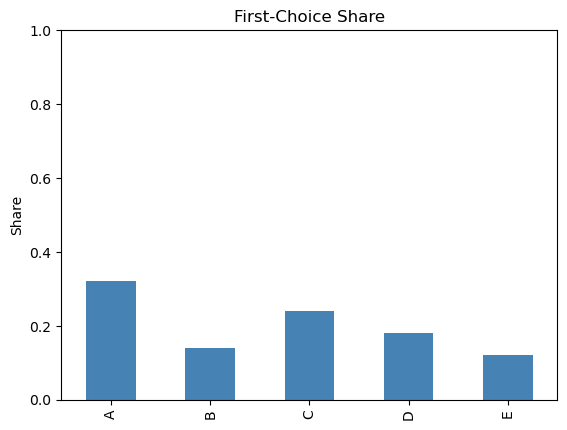

In [27]:
first_choice = (df_control == 1).sum()
(first_choice / len(df_control)).loc[option_names].plot(kind="bar", color="steelblue")
plt.ylabel("Share")
plt.title("First-Choice Share")
plt.ylim(0, 1)

In [28]:

# Create treatment data with matching column name and data type
treatment_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_dataframe(
    df=df,
    experimental_data_type="ordinal_ranking_per_agent",
    agent_id_column="name",
    value_column="Vote",
    agent_comments_column="justification",
    dataset_name="AI-enabled Story Telling Survey Simulation Results"
)

In [29]:
treatment_data

SimulationExperimentDataset(name='AI-enabled Story Telling Survey Simulation Results', description='Empirical data loaded from pandas DataFrame', key_results={'A_rank': [1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'B_rank': [3, 3, 4, 4, 4, 4, 2, 1, 2, 4, 1, 2, 4, 4, 3, 1, 3, 5, 4, 3, 3, 4, 3, 3, 5, 4, 1, 2, 3, 4, 4, 1, 3, 4, 4, 3, 3, 1, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 2, 4], 'C_rank': [2, 2, 5, 3, 2, 3, 3, 4, 4, 3, 3, 4, 3, 2, 5, 5, 2, 2, 1, 4, 2, 3, 2, 2, 3, 3, 3, 4, 1, 2, 3, 3, 4, 3, 2, 2, 2, 3, 4, 2, 2, 4, 2, 2, 2, 2, 3, 2, 3, 3], 'D_rank': [4, 4, 2, 2, 3, 2, 4, 3, 3, 2, 4, 5, 5, 3, 1, 4, 5, 3, 2, 2, 5, 2, 4, 5, 1, 2, 4, 3, 4, 3, 1, 4, 1, 2, 5, 4, 4, 4, 1, 3, 5, 2, 5, 4, 4, 5, 2, 4, 4, 2], 'E_rank': [5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 3, 2, 5, 4, 2, 4, 4, 5, 5, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 4, 5, 3, 5, 5, 4, 5, 5, 5, 5]}, result_types={'A_rank': 'per_a

In [30]:
result_ttest = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        output_format="values"
    )

In [31]:
result_ttest.overall_score

0.6055800358538093

In [32]:
result_ttest.statistical_results

{'common_metrics': ['C_rank', 'D_rank', 'B_rank', 'E_rank', 'A_rank'],
 'test_results': {'treatment': {'C_rank': {'test_type': 'Welch t-test (unequal variance)',
    'control_mean': 2.54,
    'treatment_mean': 2.8,
    'mean_difference': 0.2599999999999998,
    'percent_change': 10.236220472440936,
    't_statistic': -1.153748877891464,
    'p_value': 0.2515991183258658,
    'confidence_interval': (-0.1875841800656931, 0.7075841800656927),
    'confidence_level': 0.95,
    'significant': False,
    'degrees_of_freedom': 91.76921663853997,
    'control_sample_size': 50,
    'treatment_sample_size': 50,
    'control_std': 1.265072394476026,
    'treatment_std': 0.9689042833036098,
    'effect_size': 0.2307497755782928},
   'D_rank': {'test_type': 'Welch t-test (unequal variance)',
    'control_mean': 2.86,
    'treatment_mean': 3.24,
    'mean_difference': 0.38000000000000034,
    'percent_change': 13.2867132867133,
    't_statistic': -1.5100966538889609,
    'p_value': 0.134243126122712

In [33]:
result_ttest.semantic_results

In [34]:
result_ks = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        statistical_test_type="ks_test",
        output_format="values"
    )

In [35]:
result_ks.overall_score

0.7349816849816849

In [36]:
result_ks.statistical_results

{'common_metrics': ['C_rank', 'D_rank', 'B_rank', 'E_rank', 'A_rank'],
 'test_results': {'treatment': {'C_rank': {'test_type': 'Kolmogorov-Smirnov test',
    'control_mean': 2.54,
    'treatment_mean': 2.8,
    'control_median': 2.0,
    'treatment_median': 3.0,
    'control_std': 1.265072394476026,
    'treatment_std': 0.9689042833036098,
    'ks_statistic': 0.2,
    'p_value': 0.2719135601522248,
    'significant': False,
    'control_sample_size': 50,
    'treatment_sample_size': 50,
    'effect_size': 0.2,
    'overlap_coefficient': 0.6129032258064518,
    'percentile_differences': {'p25_diff': 0.0,
     'p50_diff': 1.0,
     'p75_diff': -0.75,
     'p90_diff': 0.0,
     'p95_diff': -0.45000000000000284},
    'interpretation': 'No significant difference between distributions',
    'confidence_level': 0.95},
   'D_rank': {'test_type': 'Kolmogorov-Smirnov test',
    'control_mean': 2.86,
    'treatment_mean': 3.24,
    'control_median': 3.0,
    'treatment_median': 3.5,
    'control_

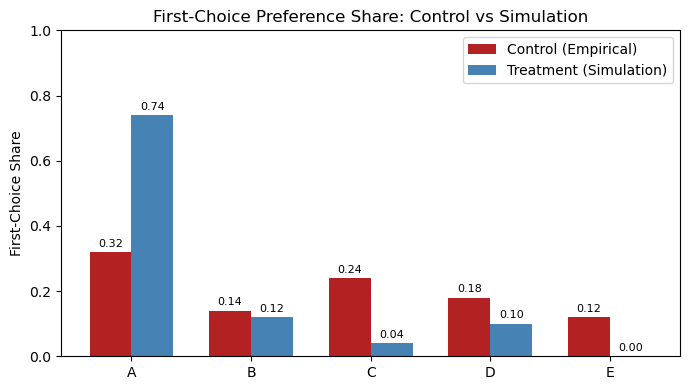

,Option,Control_FirstChoice,Treatment_FirstChoice
0,A,0.32,0.74
1,B,0.14,0.12
2,C,0.24,0.04
3,D,0.18,0.10
4,E,0.12,0.00


In [37]:
# Compare first-choice (rank==1) shares between control (empirical) and treatment (simulation)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def dataset_to_rank_df(dataset):
    rank_cols = [k for k in dataset.key_results if k.endswith("_rank")]
    opts = [c.replace("_rank", "") for c in rank_cols]
    if not rank_cols:
        raise ValueError("Dataset has no *_rank columns to compute first choices.")
    return pd.DataFrame({opt: dataset.key_results[f"{opt}_rank"] for opt in opts}), opts

# Build rank DataFrames
control_rank_df, options_control = dataset_to_rank_df(control_data)
try:
    treatment_rank_df, options_treatment = dataset_to_rank_df(treatment_data)
except Exception as e:
    # Fallback: attempt to reconstruct from original df if simulation dataset lacks expanded ranks
    if 'df' in globals():
        # Expect a column with combined ranking like "A,B,C,D,E" or single numeric; skip if not matching
        raise e
    else:
        raise e

# Ensure same option ordering
options = [opt for opt in options_control if opt in options_treatment]

# Compute first-choice shares (rank == 1)
fc_control = (control_rank_df[options] == 1).sum() / len(control_rank_df)
fc_treatment = (treatment_rank_df[options] == 1).sum() / len(treatment_rank_df)

comparison = pd.DataFrame({
    'Option': options,
    'Control_FirstChoice': [fc_control[o] for o in options],
    'Treatment_FirstChoice': [fc_treatment[o] for o in options]
})

# Plot side-by-side bars
x = np.arange(len(options))
width = 0.35
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x - width/2, comparison['Control_FirstChoice'], width, label='Control (Empirical)', color='firebrick')
ax.bar(x + width/2, comparison['Treatment_FirstChoice'], width, label='Treatment (Simulation)', color='steelblue')
ax.set_xticks(x)
ax.set_xticklabels(options)
ax.set_ylabel('First-Choice Share')
ax.set_ylim(0, 1)
ax.set_title('First-Choice Preference Share: Control vs Simulation')

for i, val in enumerate(comparison['Control_FirstChoice']):
    ax.text(x[i] - width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=8)
for i, val in enumerate(comparison['Treatment_FirstChoice']):
    ax.text(x[i] + width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=8)

ax.legend()
plt.tight_layout()
plt.show()

comparison

## Borda Count Comparison
This section computes Borda scores (higher is better) for each option in the empirical control data vs the simulation treatment data. Rank 1 gets the maximum points (N-1), rank N gets 0. We also show normalized scores (0-1) and the difference.

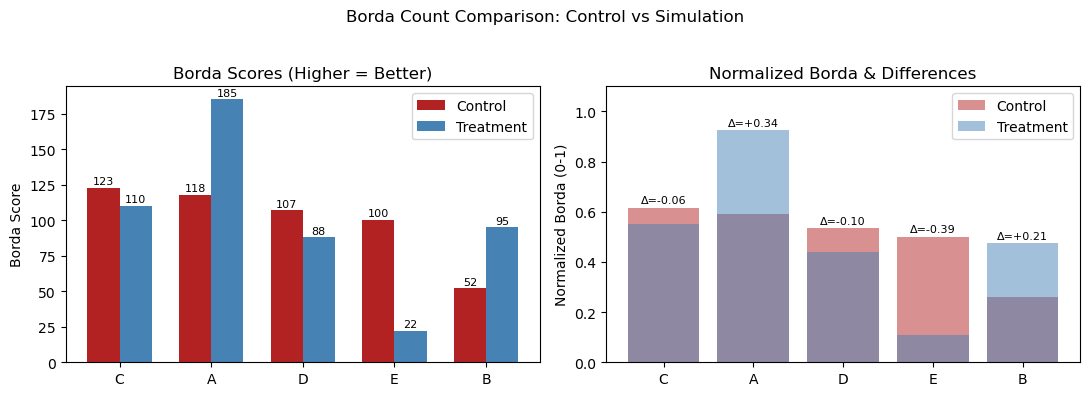

,Option,Control_Borda,Treatment_Borda,Control_Borda_Norm,Treatment_Borda_Norm,Norm_Diff
2,C,123,110,0.615,0.550,-0.065
0,A,118,185,0.590,0.925,0.335
3,D,107,88,0.535,0.440,-0.095
4,E,100,22,0.500,0.110,-0.390
1,B,52,95,0.260,0.475,0.215


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse existing rank DataFrames: control_rank_df, treatment_rank_df, and options list
# Points scheme: with K options, rank 1 -> K-1 points, rank K -> 0 points
K = len(options)
points = {r: (K - r) for r in range(1, K+1)}

borda_control = control_rank_df[options].replace(points).sum()
borda_treatment = treatment_rank_df[options].replace(points).sum()

# Normalize (divide by max possible = (K-1) * number_of_respondents)
max_points_control = (K-1) * len(control_rank_df)
max_points_treatment = (K-1) * len(treatment_rank_df)

borda_control_norm = borda_control / max_points_control
borda_treatment_norm = borda_treatment / max_points_treatment

borda_df = pd.DataFrame({
    'Option': options,
    'Control_Borda': borda_control.values,
    'Treatment_Borda': borda_treatment.values,
    'Control_Borda_Norm': borda_control_norm.values,
    'Treatment_Borda_Norm': borda_treatment_norm.values,
})

borda_df['Norm_Diff'] = borda_df['Treatment_Borda_Norm'] - borda_df['Control_Borda_Norm']

# Order by control Borda descending for consistency
borda_df = borda_df.sort_values('Control_Borda', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(11,4))
# Absolute Borda scores
x = np.arange(len(borda_df))
width = 0.35
axes[0].bar(x - width/2, borda_df['Control_Borda'], width, label='Control', color='firebrick')
axes[0].bar(x + width/2, borda_df['Treatment_Borda'], width, label='Treatment', color='steelblue')
axes[0].set_xticks(x)
axes[0].set_xticklabels(borda_df['Option'])
axes[0].set_ylabel('Borda Score')
axes[0].set_title('Borda Scores (Higher = Better)')
axes[0].legend()
for i, v in enumerate(borda_df['Control_Borda']):
    axes[0].text(i - width/2, v + max(borda_df['Control_Borda'])*0.01, f"{int(v)}", ha='center', va='bottom', fontsize=8)
for i, v in enumerate(borda_df['Treatment_Borda']):
    axes[0].text(i + width/2, v + max(borda_df['Control_Borda'])*0.01, f"{int(v)}", ha='center', va='bottom', fontsize=8)

# Normalized difference plot
axes[1].bar(borda_df['Option'], borda_df['Control_Borda_Norm'], alpha=0.5, label='Control', color='firebrick')
axes[1].bar(borda_df['Option'], borda_df['Treatment_Borda_Norm'], alpha=0.5, label='Treatment', color='steelblue')
for i, opt in enumerate(borda_df['Option']):
    c_val = borda_df.iloc[i]['Control_Borda_Norm']
    t_val = borda_df.iloc[i]['Treatment_Borda_Norm']
    axes[1].text(i, max(c_val, t_val) + 0.01, f"Δ={t_val - c_val:+.02f}", ha='center', va='bottom', fontsize=8)
axes[1].set_ylim(0, 1.1)
axes[1].set_ylabel('Normalized Borda (0-1)')
axes[1].set_title('Normalized Borda & Differences')
axes[1].legend()

plt.suptitle('Borda Count Comparison: Control vs Simulation')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

borda_df